I use the table of content (toc2) plugin with Jupyter Notebook. I sugget you install this plugin to navigate this markdown. Use the toc on the left to view each part of the analysis.

The plugin can be installed from http://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/toc2/README.html

## Install packages

In [117]:
import sys
import pandas as pd
import numpy as np
#from kmean_clustering import kmean_clustering as kc

from sklearn.metrics import silhouette_samples, silhouette_score

In [118]:
print('Python')
print(sys.version)
print('Numpy')
print(np.__version__)
print('Pandas')
print(pd.__version__)

Python
3.5.3 |Continuum Analytics, Inc.| (default, Mar  6 2017, 11:58:13) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Numpy
1.12.1
Pandas
0.20.1


Use Python3 to run this notebook. 

## Functions

Those functions have been wrapped into a python package. You can install the package from github and import it. I just load the functions here because it's easy for me to debug.

In [119]:
def plot_weight_matrix(weight_matrix):
    plt.imshow(weight_matrix)
    plt.show()

In [120]:
from  scipy.spatial.distance import pdist,squareform,cdist
#from scipy.spatial import distance_matrix
#import matplotlib.pyplot as plt
import scipy


def k_means(data, n_clusters=3, n_init=20, max_iter=100, kernel=None,
            verbose=False,sigma = 1.0,use_kmean_controid=False):
    '''
    data: a numeric numpy array
    n_clusters: number of clusters
    n_init: number of different initializations to run kmeans
    max_iter: number of max iterations 
    kernel: "None", regular k means; "gaussian",  k means with gaussian kernel
    verbose: output detailed information
    sigma: the sigma parameter in the gaussian kernel 
    use_kmean_controid: for kenel K means, use the best controids from K means as initialization points.
    '''
    ### may not be efficient in terms of memory use
    ### no need to save whole history
    ### get whole hitory for debugging purpose
    controid_history = {}
    cluster_label_history = {}
    sse_history = np.zeros(shape=(n_init,1))
    ### start k-means
    n_points = data.shape[0]
    ### calculate the kernel matrix
    if kernel == 'gaussian':
        ### 'sqeuclidean': squared Euclidean distance
        kernel_matrix = np.exp(-0.5/(sigma**2)*squareform(pdist(data,'sqeuclidean')))
    ### repeat k-means n_init times 
    ### return the best one 
    np.seterr(divide='ignore', invalid='ignore')
    for i_init in range(n_init):
        if verbose: print('Random seed',i_init)
        #### set random seed
        np.random.seed(i_init)
        #### generate initial cluster labels
        cluster_labels = np.random.choice(range(n_clusters),size=n_points, replace=True)
        #### generate initial centroids
        #### randomly choose n_clusters points from the data as centroids
        if use_kmean_controid:
            #### run one K means
            print('Use best K means centroid')
            km_result = k_means(data, n_clusters, n_init=20, max_iter=100, kernel=None)
            centroids = km_result['best_controids']
        else:
            #### randomly choose n_clusters points from the data as centroids
            centroids = data[np.random.choice(np.arange(n_points), n_clusters, replace=False),:]
        for i_iter in range(max_iter):
            if verbose: print('Iteration',i_iter,end=', ')
            distance_to_centroids = np.zeros(shape=(data.shape[0],n_clusters))
            ######
            if kernel is None:
                distance_to_centroids = scipy.spatial.distance.cdist(data, centroids, 'euclidean')
            ######
            elif kernel == 'gaussian':
                dist1 = np.diag(kernel_matrix)
                cluster_ind_matrix = np.zeros(shape=(data.shape[0],n_clusters))
                for i_centroid in range(n_clusters):
                    cluster_ind_matrix[:,i_centroid] = (cluster_labels == i_centroid) + 0.0
                    kth_cluster_ind = (cluster_labels == i_centroid) + 0.0
                    kth_cluster_matrix = np.outer(kth_cluster_ind,kth_cluster_ind)
                    
                    dist2 = 2.0*np.sum(np.tile(kth_cluster_ind,(n_points,1))*kernel_matrix,axis=1)/np.sum(kth_cluster_ind)
                    dist3 = np.sum(kth_cluster_matrix*kernel_matrix)/np.sum(kth_cluster_matrix)
                    #print(dist1.shape,dist2.shape,dist3.shape,)
                    ### ord=2 is L2 distance
                    ### axis=1 is to calculate norm along columns
                    distance_to_centroids[:,i_centroid] = dist1-dist2+dist3
                    #break
            else:
                sys.exit('Kernel parameter is not correct!')
            #print(distance_to_centroids)
            ### assign the cluster labels
            cluster_labels = np.argmin(distance_to_centroids,axis=1)
            sse = np.sum((np.min(distance_to_centroids,axis=1))**2)
            if verbose: print('SSE',sse)
            ### re-calculate centroids
            previous_centroids = centroids
            centroids = np.array([data[cluster_labels == i_centroid].mean(axis = 0) for i_centroid in range(n_clusters)])
            ### if centroids don't change
            ### stop the iteration
            if np.all(previous_centroids == centroids):
                if verbose: print('Centroids do not change',i_iter)
                break
            #break
        controid_history[i_init] = centroids
        cluster_label_history[i_init] = cluster_labels
        sse_history[i_init] = sse
        #break
    np.seterr(divide='warn', invalid='warn')
    ### find the best initializations
    best_iter = np.argmin(sse_history)
    best_sse = sse_history[best_iter]
    best_controids = controid_history[best_iter]
    best_cluster_label = cluster_label_history[best_iter]
    
    return {'best_iter':best_iter,
            'best_sse':best_sse,
            'best_controids':best_controids,
            'best_cluster_label':best_cluster_label,
            'controid_history':controid_history,
            'cluster_label_history':cluster_label_history,
            'sse_history':sse_history,
           }

In [121]:
### Matrix version
### Slightly slower than the "for loop" version
import scipy
#from scipy.spatial import distance_matrix

def adaptive_cluster(data, gap_par = 0.5, debug=False):
    '''
    data:: a numeric numpy array
    gap_par: the lambda parameter used to test the gap
    debug: for debug
    '''
    weight_matrix_history = []
    (n_points,n_features) = data.shape
    distance_matrix = scipy.spatial.distance_matrix(data,data)
    #print('distance_matrix.shape',distance_matrix.shape)
    weight_matrix = np.zeros(shape=(n_points,n_points))
    weight_matrix_history.append((0,weight_matrix))
    #print('weight_matrix.shape',weight_matrix.shape)
    #plot_weight_matrix(weight_matrix)
    ### sort the distance matrix
    sorted_distance_idx_matrix = np.argsort(distance_matrix,axis=1)
    sorted_distance_matrix = np.sort(distance_matrix,axis=1)
    #print('sorted_distance_matrix.shape',sorted_distance_matrix.shape)    
    #print('sorted_distance_idx_matrix.shape',sorted_distance_idx_matrix.shape)
    ### number of neighbors
    n0 = 2*n_features+2
    ### h0 is the the radius such that the point has n0 neighbors 
    h0 = sorted_distance_matrix[:,n0]
    #print('h0.shape',h0.shape)
    ### max(h0(Xi),h0(Xj))
    max_h0 = np.reshape([np.maximum(h0[i],h0[j]) for i in range(n_points) for j in range(n_points)],newshape=(n_points,n_points))
    #print('max_h0.shape',max_h0.shape)
    ### weight_matrix
    weight_matrix = (distance_matrix <= max_h0).astype('int')
    #print('weight_matrix.shape',weight_matrix.shape)
    #plot_weight_matrix(weight_matrix)


    #################################################################
    ### find h sequence
    a = 1.4142135623730951
    b = 1.95
    #gap_par = -1 
    max_distance = np.max(sorted_distance_matrix)
    ### h0 is a vector, each data point has n0 neighbors
    ### max(h0) makes sure that each data point has at least n0 neighbors
    h_array  = np.array([np.max(h0)])
    #n_matrix = np.repeat(n0, n_points)
    #n_matrix = n_matrix[:,np.newaxis]
    k = 0
    weight_matrix_history.append((h_array[k],weight_matrix))
    while h_array[k] <= max_distance:
        ### upper bound of n(Xi,h_k+1)
        ### given radius h_array[k], how many neighbors for each data point
        ### -1 removes its self from counting
        n_upper = a * np.array([np.sum(sorted_distance_matrix[i,:]<=h_array[k])-1 for i in np.arange(n_points)])
        n_upper = (np.floor(n_upper)).astype('int')
        ### when h is big, the n_upper may be > n_points
        n_upper = np.clip(n_upper, a_min=None,a_max=(n_points-1))
        #print(n_upper)
        ### n_upper can decide the h_upper
        h_upper_by_n_upper = np.min(np.array([sorted_distance_matrix[i,n_upper[i]] for i in np.arange(n_points)]))
        ### upper bound of h_k+1
        h_upper = b*h_array[k]
        ### must satisfy both conditions
        min_h_upper = np.minimum(h_upper_by_n_upper,h_upper)
        #print(k,min_h_upper)
        ### append to the h_array
        ### just make sure h is not > max_distance
        if min_h_upper <= max_distance:
            if  min_h_upper <= h_array[k]: break
            #print(k,'h',min_h_upper)
            h_array = np.append(h_array,min_h_upper)
        k = k + 1

    #################################################################    
    ### check if those h satisfy the conditions
    if debug:
        for k in range(1,len(h_array)):  
            if h_array[k] <= b*h_array[k-1]:
                continue
                print('k',k,h_array[k],h_array[k-1],b*h_array[k-1],end=',')
                print(h_array[k]/h_array[k-1])
            else:
                print('h error')
        for k in range(1,len(h_array)):
            for i in range(n_points):
                n1 = np.sum(sorted_distance_matrix[i,:]<=h_array[k-1])-1 
                n2 = np.sum(sorted_distance_matrix[i,:]<=h_array[k])-1 
                if n2<=a*n1 and n1>=n0 and n2>=n0:
                    continue
                    print('n',k,n1,n2,a*n1,end=',')
                    print(n2/n1)
                else:
                    print('n error')
        
    #################################################################
    beta_a = (n_features+1.0)/2.0
    beta_b = 0.5
    beta_function = scipy.special.beta(beta_a,beta_b)

    np.seterr(divide='ignore', invalid='ignore')  

    for k in range(1,len(h_array)):
        #print('h_k',h_array[k])
        distance_matrix_temp = distance_matrix.copy()
        distance_matrix_temp = np.where(distance_matrix_temp <= h_array[k], distance_matrix_temp, np.nan)  
        #weight_matrix = (distance_matrix <= h_array[k]).astype('int')
        #plot_weight_matrix(weight_matrix)
        #### caclulate overlap
        ### repalce l=i,j elements  to 0
        ### no need to consider l!=i,j elements in the following calculation
        np.fill_diagonal(weight_matrix,0) 
        N_overlap = [np.dot(weight_matrix[i,:],weight_matrix[j,:]) for i in range(n_points) for j in range(n_points)]
        N_overlap = np.reshape(N_overlap,newshape=(n_points,n_points))
        #### caclulate complement
        N_complement = np.zeros(shape=(n_points,n_points))
        for i in range(n_points):
            for j in range(n_points):
                if k>1:
                    ind1 = (distance_matrix[j,:] > h_array[k-1]).astype('int')
                    ind2 = (distance_matrix[i,:] > h_array[k-1]).astype('int')
                if k==1:
                    ind1 = (distance_matrix[j,:] > np.maximum(h0[i],h0[j])).astype('int')
                    ind2 = (distance_matrix[i,:] > np.maximum(h0[i],h0[j])).astype('int')
                N_complement[i,j] = np.dot(weight_matrix[i,:],ind1) + np.dot(weight_matrix[j,:],ind2)
        ### repalce l=i,j elements back to 1
        np.fill_diagonal(weight_matrix,1)
        #### caclulate union
        N_union = N_overlap + N_complement
        #### theta
        theta = N_overlap / N_union
        #### q
        t = distance_matrix_temp/h_array[k-1]
        beta_x = 1.0-(t**2)/4.0
        incomplete_beta_function = scipy.special.betainc(beta_a,beta_b,beta_x)
        q = incomplete_beta_function / (2*beta_function-incomplete_beta_function)
        T1 = N_union
        #### this may raise warnings about log(0) or log(nan)
        #### this is fine, since I used the whole matrix here
        #### some of the points are out of the h(k) radius
        #### we will mask those points in the later step
        T2 = theta*np.log(theta/q)+(1.0-theta)*np.log((1.0-theta)/(1.0-q))
        #### when N_overlap is 0, theta is 0, this leands to T is nan
        #### replace those nan with 0 in T
        #T2 = np.where(theta==0.0,0.0,T2)
        #T2 = np.where(theta==1.0,0.0,T2)
        T3 = ((theta<=q).astype('int')-(theta>q).astype('int'))
        T = T1 * T2 * T3
        ####
        ####
        weight_matrix = ((distance_matrix<=h_array[k]) * (T<=gap_par)).astype('int')
        #### be careful with those boundary points
        #### theta=0 means no overlap at all
        #### theta=1 means completely overlap
        #### needs special treatment for them
        weight_matrix = np.where(theta==0,0,weight_matrix)
        weight_matrix = np.where(theta==1,1,weight_matrix)
        np.fill_diagonal(weight_matrix,1)
        #plot_weight_matrix(weight_matrix)
        #break
        weight_matrix_history.append((h_array[k],weight_matrix))
        
    ### reset to default
    np.seterr(divide='warn', invalid='warn')  
    
    ### calculate S
    S = np.sum(weight_matrix)
    
    ### extract clusters from weight matrix
    labels = (np.zeros(shape=weight_matrix.shape[0]))
    labels.fill(np.nan)
    cluster_ind = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i == j:continue
            if weight_matrix[i,j] == 1:
                if np.isnan(labels[i]) and np.isnan(labels[j]):
                    labels[i] = cluster_ind
                    labels[j] = cluster_ind
                    cluster_ind = cluster_ind + 1
                elif not np.isnan(labels[i]) and np.isnan(labels[j]):
                    labels[j] = labels[i]
                elif  np.isnan(labels[i]) and not np.isnan(labels[j]):
                    labels[i] = labels[j]
                elif  not np.isnan(labels[i]) and  not np.isnan(labels[j]):
                    continue
                else:
                    print(i,j,labels[i],labels[j])
                    print('cluster assignment error')
    ### some points may not belong to any cluster
    ### assign those points to the nearest cluster
    ### or they can be ignored (by default, those points will have np.nan as labels)
    ### thus those points can be considered as outliers
    if np.sum(np.isnan(labels))>0:
        nan_ind = np.argwhere(np.isnan(labels)).flatten()
        for i in nan_ind:
            dist = distance_matrix[i,:].copy()
            dist[i] = np.max(dist)
            nearest_ind = np.argmin(dist)
            labels[i] = labels[nearest_ind]
            
    return({"S":S,"weight_matrix":weight_matrix,
            "cluster_label":labels,
            "weight_matrix_history":weight_matrix_history,
           })
        

In [122]:
### for loop version
### run this cell to overwrite the previous matrix version
### because this version is faster

import scipy
#from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist

def adaptive_cluster(data, gap_par = 0.5, n0=None,debug=False,assign_outliers = 'nearest_cluster'):
    '''
    data:: a numeric numpy array
    gap_par: the lambda parameter used to test the gap
    n0: the initial neighbors for each data point. 
    debug: for debug
    assign_outliers: nearest_cluster, assign outliers to nearest cluster. new_cluster, assign outliers to a new cluster
    '''
    weight_matrix_history = []
    (n_points,n_features) = data.shape
    #distance_matrix = scipy.spatial.distance_matrix(data,data)
    ## faster version
    distance_matrix = scipy.spatial.distance.cdist(data, data, 'euclidean')
    #print('distance_matrix.shape',distance_matrix.shape)
    weight_matrix = np.zeros(shape=(n_points,n_points))
    weight_matrix_history.append((0,weight_matrix))
    #print('weight_matrix.shape',weight_matrix.shape)
    #plot_weight_matrix(weight_matrix)
    ### sort the distance matrix
    sorted_distance_idx_matrix = np.argsort(distance_matrix,axis=1)
    sorted_distance_matrix = np.sort(distance_matrix,axis=1)
    #print('sorted_distance_matrix.shape',sorted_distance_matrix.shape)    
    #print('sorted_distance_idx_matrix.shape',sorted_distance_idx_matrix.shape)
    ### number of neighbors
    if n0 is None:
        n0 = 2*n_features+2
    ### h0 is the the radius such that the point has n0 neighbors 
    h0 = sorted_distance_matrix[:,n0]
    #print('h0.shape',h0.shape)
    ### max(h0(Xi),h0(Xj))
    #max_h0 = np.reshape([np.maximum(h0[i],h0[j]) for i in range(n_points) for j in range(n_points)],newshape=(n_points,n_points))
    #print('max_h0.shape',max_h0.shape)
    ### weight_matrix
    #weight_matrix = (distance_matrix <= max_h0).astype('int')
    ### faster version
    h0_matrix = np.tile(h0, (n_points, 1))
    h0_matrix_T = h0_matrix.T
    h0_matrix_max = np.maximum(h0_matrix,h0_matrix_T)
    weight_matrix = (distance_matrix<=h0_matrix_max).astype('int')
    #print('weight_matrix.shape',weight_matrix.shape)
    #plot_weight_matrix(weight_matrix)


    #################################################################
    ### find h sequence
    a = 1.4142135623730951
    b = 1.95
    #gap_par = -1 
    max_distance = np.max(sorted_distance_matrix)
    ### h0 is a vector, each data point has n0 neighbors
    ### max(h0) makes sure that each data point has at least n0 neighbors
    h_array  = np.array([np.max(h0)])
    #n_matrix = np.repeat(n0, n_points)
    #n_matrix = n_matrix[:,np.newaxis]
    k = 0
    weight_matrix_history.append((h_array[k],weight_matrix.copy()))
    while h_array[k] <= max_distance:
        ### upper bound of n(Xi,h_k+1)
        ### given radius h_array[k], how many neighbors for each data point
        ### -1 removes its self from counting
        n_upper = a * np.array([np.sum(sorted_distance_matrix[i,:]<=h_array[k])-1 for i in np.arange(n_points)])
        n_upper = (np.floor(n_upper)).astype('int')
        ### when h is big, the n_upper may be > n_points
        n_upper = np.clip(n_upper, a_min=None,a_max=(n_points-1))
        #print(n_upper)
        ### n_upper can decide the h_upper
        h_upper_by_n_upper = np.min(np.array([sorted_distance_matrix[i,n_upper[i]] for i in np.arange(n_points)]))
        ### upper bound of h_k+1
        h_upper = b*h_array[k]
        ### must satisfy both conditions
        min_h_upper = np.minimum(h_upper_by_n_upper,h_upper)
        #print(k,min_h_upper)
        ### append to the h_array
        ### just make sure h is not > max_distance
        if min_h_upper <= max_distance:
            if  min_h_upper <= h_array[k]: break
            #print(k,'h',min_h_upper)
            h_array = np.append(h_array,min_h_upper)
        k = k + 1

    #################################################################    
    ### check if those h satisfy the conditions
    if debug:
        for k in range(1,len(h_array)):  
            if h_array[k] <= b*h_array[k-1]:
                continue
                print('k',k,h_array[k],h_array[k-1],b*h_array[k-1],end=',')
                print(h_array[k]/h_array[k-1])
            else:
                print('h error')
        for k in range(1,len(h_array)):
            for i in range(n_points):
                n1 = np.sum(sorted_distance_matrix[i,:]<=h_array[k-1])-1 
                n2 = np.sum(sorted_distance_matrix[i,:]<=h_array[k])-1 
                if n2<=a*n1 and n1>=n0 and n2>=n0:
                    continue
                    print('n',k,n1,n2,a*n1,end=',')
                    print(n2/n1)
                else:
                    print('n error')
        
    #################################################################
    beta_a = (n_features+1.0)/2.0
    beta_b = 0.5
    beta_function = scipy.special.beta(beta_a,beta_b)

    np.seterr(divide='ignore', invalid='ignore')  
    #print('h_k',h_array[0])
    for k in range(1,len(h_array)):
        #print('h_k',h_array[k])
        #t_matrix = distance_matrix/h_array[k-1]
        #beta_x_matrix = 1.0-(t_matrix**2)/4.0
        #incomplete_beta_function_matrix = scipy.special.betainc(beta_a,beta_b,beta_x_matrix)
        #q_matrix = incomplete_beta_function_matrix / (2*beta_function-incomplete_beta_function_matrix)
        for i in range(n_points):
            weight_matrix[i,i] = 1
            for j in range(i,n_points):
                #if  weight_matrix[i,j] == 1:
                #    continue
                #if i == j: 
                #    weight_matrix[i,j] = 1
                #    continue
                #if i > j:
                #    weight_matrix[i,j] = weight_matrix[j,i]
                #   continue
                if distance_matrix[i,j] <= h_array[k] and h_array[k-1] >= h0[i] and h_array[k-1] >= h0[j]:
                    #### caclulate overlap
                    N_overlap = np.dot(weight_matrix[i,:],weight_matrix[j,:])
                    #### caclulate complement
                    #N_complement = np.zeros(shape=(n_points,n_points))
                    if k>1:
                        ind1 = (distance_matrix[j,:] > h_array[k-1]) + 0.0
                        ind2 = (distance_matrix[i,:] > h_array[k-1]) + 0.0
                    else:
                        ind1 = (distance_matrix[j,:] > h0_matrix_max[i,j]) + 0.0
                        ind2 = (distance_matrix[i,:] > h0_matrix_max[i,j]) + 0.0
                    N_complement = np.dot(weight_matrix[i,:],ind1) + np.dot(weight_matrix[j,:],ind2)
                    #### caclulate union
                    N_union = N_overlap + N_complement
                    #### theta
                    theta = N_overlap / N_union
                    #### q
                    t = distance_matrix[i,j]/h_array[k-1]
                    beta_x = 1.0-(t**2)/4.0
                    incomplete_beta_function = scipy.special.betainc(beta_a,beta_b,beta_x)
                    q = incomplete_beta_function / (2*beta_function-incomplete_beta_function)
                    #q = q_matrix[i,j]
                    T1 = N_union
                    #### this may raise warnings about log(0) or log(nan)
                    #### this is fine, since I used the whole matrix here
                    #### some of the points are out of the h(k) radius
                    #### we will mask those points in the later step
                    T2 = theta*np.log(theta/q)+(1.0-theta)*np.log((1.0-theta)/(1.0-q))
                    #### when N_overlap is 0, theta is 0, this leands to T is nan
                    #### replace those nan with 0 in T
                    #T2 = np.where(theta==0.0,0.0,T2)
                    #T2 = np.where(theta==1.0,0.0,T2)
                    #T3 = ((theta<=q).astype('int')-(theta>q).astype('int'))
                    ### faster version
                    if theta<=q:
                        T = T1 * T2
                    else:
                        T = - (T1 * T2)
                    #T = T1 * T2 * T3
                    ####
                    ####
                    #weight_matrix[i,j] = (distance_matrix[i,j]<=h_array[k]) * (T<=gap_par) + 0.0
                    weight_matrix[i,j] = (T<=gap_par) + 0.0
                    #### be careful with those boundary points
                    #### theta=0 means no overlap at all
                    #### theta=1 means completely overlap
                    #### needs special treatment for them
                    if theta==0: weight_matrix[i,j] = 0 
                    if theta==1: weight_matrix[i,j] = 1
                    ####
                    weight_matrix[j,i] = weight_matrix[i,j]
        weight_matrix_history.append((h_array[k],weight_matrix.copy()))
        
    ### reset to default
    np.seterr(divide='warn', invalid='warn')  
    
    ### calculate S
    S = np.sum(weight_matrix)
    
    ### extract clusters from weight matrix
    labels = (np.zeros(shape=weight_matrix.shape[0]))
    labels.fill(np.nan)
    cluster_ind = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i == j:continue
            if weight_matrix[i,j] == 1:
                if np.isnan(labels[i]) and np.isnan(labels[j]):
                    labels[i] = cluster_ind
                    labels[j] = cluster_ind
                    cluster_ind = cluster_ind + 1
                elif not np.isnan(labels[i]) and np.isnan(labels[j]):
                    labels[j] = labels[i]
                elif  np.isnan(labels[i]) and not np.isnan(labels[j]):
                    labels[i] = labels[j]
                elif  not np.isnan(labels[i]) and  not np.isnan(labels[j]):
                    continue
                else:
                    print(i,j,labels[i],labels[j])
                    print('cluster assignment error')
    ### some points may not belong to any cluster
    ### assign those points to the nearest cluster
    ### or they can be ignored (by default, those points will have np.nan as labels)
    ### thus those points can be considered as outliers
    if assign_outliers == 'nearest_cluster':
        if np.sum(np.isnan(labels))>0:
            nan_ind = np.argwhere(np.isnan(labels)).flatten()
            for i in nan_ind:
                dist = distance_matrix[i,:].copy()
                dist[i] = np.max(dist)
                nearest_ind = np.argmin(dist)
                labels[i] = labels[nearest_ind]
                #print(dist)
                #print(i,nearest_ind)
    elif assign_outliers == 'new_cluster':
        if np.sum(np.isnan(labels))>0:
            nan_ind = np.argwhere(np.isnan(labels)).flatten()
            outlier_label = np.nanmax(np.unique(labels)) + 1
            for i in nan_ind:
                labels[i] = outlier_label
    else:
        print('assign_outliers parameter is not correct')
            
    return({"S":S,"weight_matrix":weight_matrix,
            "cluster_label":labels,
            "weight_matrix_history":weight_matrix_history,
           })
        

## Load test data

I generated some test data to validate the implementations of the three methods. 

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)
data = np.vstack((X[y == 0][:100], X[y == 1][:100], X[y == 2][:100]))
plt.scatter(data[:, 0], data[:, 1])
plt.show()

In [124]:
data.shape

(300, 2)

### Test run

Use a simulated dataset to test the implementation of the three methods. The dataset has three well separated clusters. The implemented methods should be able to find those three clusters. 

### K means

In [125]:
result = k_means(data,n_clusters=3,n_init=50,verbose=False,kernel=None)
y_pred = result['best_cluster_label']
plt.scatter(data[:, 0], data[:, 1], c=y_pred)
plt.title("K means")
plt.show()

### Find best number of clusters

Use silhouette score to infer number of clusters from data

In [126]:
n_clusters_range = range(2,8)
silhouette_mean_array   = []
silhouette_median_array = []
for n_clusters in n_clusters_range:
    result = k_means(data,n_clusters=n_clusters,n_init=50,verbose=False,kernel=None)
    y_pred = result['best_cluster_label']
    silhouette_avg = silhouette_score(data, y_pred)
    sample_silhouette_values = silhouette_samples(data, y_pred)
    silhouette_median = np.median(sample_silhouette_values)
    print("n_clusters ", n_clusters, "silhouette score:", silhouette_avg,silhouette_median)
    silhouette_mean_array.append(silhouette_avg)
    silhouette_median_array.append(silhouette_median)


print('Best n_clusters',n_clusters_range[np.argmax(silhouette_mean_array)],n_clusters_range[np.argmax(silhouette_median_array)] )

n_clusters  2 silhouette score: 0.633340667363 0.677512609006
n_clusters  3 silhouette score: 0.744349192975 0.763614204795
n_clusters  4 silhouette score: 0.612852308706 0.696763102977
n_clusters  5 silhouette score: 0.479922764374 0.490398019055
n_clusters  6 silhouette score: 0.34484658943 0.378316622207
n_clusters  7 silhouette score: 0.356315866804 0.379743598884
Best n_clusters 3 3


### Kernel k means

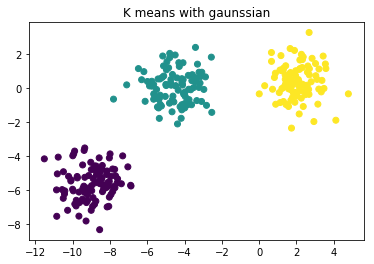

In [127]:
result = k_means(data,n_clusters=3,n_init=50,verbose=False,kernel='gaussian')
y_pred = result['best_cluster_label']
plt.scatter(data[:, 0], data[:, 1], c=y_pred)
plt.title("K means with gaunssian")
plt.show()

### Find best number of clusters

In [128]:
n_clusters_range = range(2,8)
silhouette_mean_array   = []
silhouette_median_array = []
for n_clusters in n_clusters_range:
    result = k_means(data,n_clusters=n_clusters,n_init=50,verbose=False,kernel='gaussian')
    y_pred = result['best_cluster_label']
    silhouette_avg = silhouette_score(data, y_pred)
    sample_silhouette_values = silhouette_samples(data, y_pred)
    silhouette_median = np.median(sample_silhouette_values)
    print("n_clusters ", n_clusters, "silhouette score:", silhouette_avg,silhouette_median)
    silhouette_mean_array.append(silhouette_avg)
    silhouette_median_array.append(silhouette_median)

print('Best n_clusters',n_clusters_range[np.argmax(silhouette_mean_array)],n_clusters_range[np.argmax(silhouette_median_array)] )

n_clusters  2 silhouette score: 0.555840679308 0.623751311102
n_clusters  3 silhouette score: 0.744349192975 0.763614204795
n_clusters  4 silhouette score: 0.579281574972 0.664218566108
n_clusters  5 silhouette score: 0.384914377163 0.516133756806
n_clusters  6 silhouette score: 0.301064958295 0.435642508475
n_clusters  7 silhouette score: 0.256452585721 0.409263631233
Best n_clusters 3 3


### Adaptive clustering

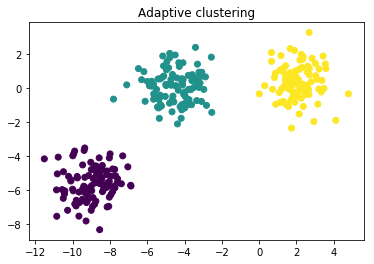

In [129]:
result = adaptive_cluster(data, gap_par = 0.5, debug=False)
y_pred = result['cluster_label']
plt.scatter(data[:, 0], data[:, 1], c=y_pred)
plt.title("Adaptive clustering")
plt.show()

### Plot history of weight matrix

k= 0


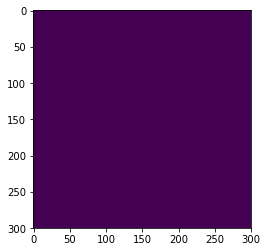

k= 2.15050808574


k= 2.18476360896


k= 2.29830180472


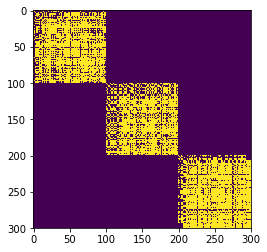

k= 2.37614649893


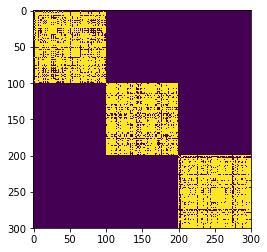

k= 2.46827457131


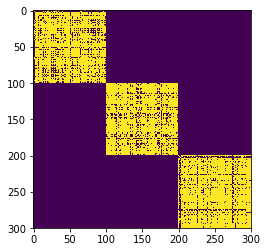

k= 2.60821602447


k= 2.68707680625


k= 2.94684785367


k= 3.16816052924


k= 3.42088839046


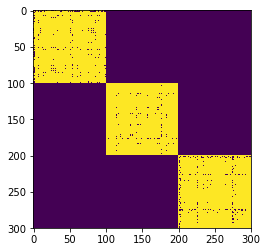

k= 3.79541067885


k= 4.1731661935


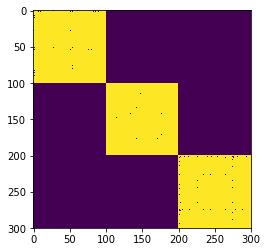

k= 4.87319883453


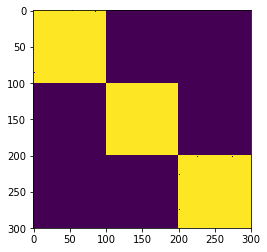

k= 5.60090784354


k= 6.0782630965


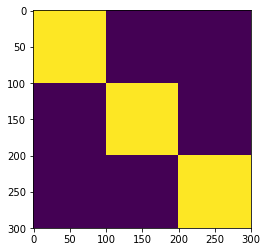

k= 6.59802894613


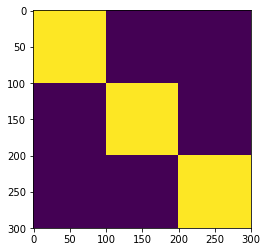

k= 7.17260323846


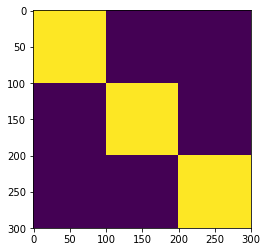

k= 7.92900753664


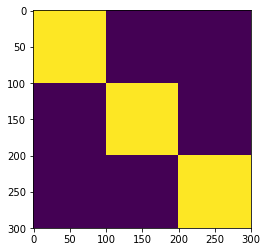

k= 9.0740414997


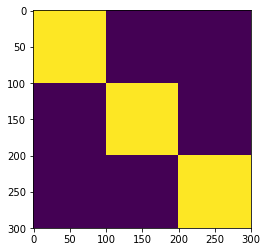

In [130]:
for (k,weight_matrix) in result['weight_matrix_history']:
    print('k=',k)
    plot_weight_matrix(weight_matrix)

### Find best lambda

Use the largest average silhouette score to choose the best lambda

In [58]:
S_array = []
silhouette_mean_array = []
silhouette_median = []
gap_pars = np.linspace(0.1,5,num=4)
for gap_par in gap_pars:
    print("gap_par",gap_par)
    result = adaptive_cluster(data, gap_par = gap_par, debug=False)
    S = result['S']
    S_array.append(S)
    #################
    y_pred = result['cluster_label']
    silhouette_avg = silhouette_score(data, y_pred)
    sample_silhouette_values = silhouette_samples(data, y_pred)
    silhouette_median = np.median(sample_silhouette_values)
    #print("n_clusters ", n_clusters, "silhouette score:", silhouette_avg,silhouette_median)
    silhouette_mean_array.append(silhouette_avg)
    silhouette_median_array.append(silhouette_median)
    ##################
    print(gap_par,"S",S,"silhouette score:", silhouette_avg,silhouette_median)

gap_par 0.1
0.1 S 28164 silhouette score: 0.443364873911 0.711426427307
gap_par 1.73333333333
1.73333333333 S 30000 silhouette score: 0.744349192975 0.763614204795
gap_par 3.36666666667
3.36666666667 S 30000 silhouette score: 0.744349192975 0.763614204795
gap_par 5.0
5.0 S 30000 silhouette score: 0.744349192975 0.763614204795


## Load real data

### Shape data

In [61]:
cluster_data = {}
sim_data_names = ['Aggregation',  'Compound',  'D31',  'flame', 'jain',  'pathbased',  'R15',  'spiral']

In [62]:
for dn in sim_data_names:
    raw_data = pd.read_csv('../data/%s.txt' % dn,sep='\t',header=None)
    label = raw_data.iloc[:,2].values
    data   = raw_data.drop(2,axis=1).values
    cluster_data[dn] = (data,label)
    #print(dn,'#true clusters',cluster_data[dn].iloc[:,2].nunique())
    del(raw_data,data,label)
    #cluster_data[dn].head()

### UCI

I didn't use the data from https://cs.joensuu.fi/sipu/datasets/. Because some data seem incorrect. For example, wine data should have 13 features, but the data on the website have 14 columns and none of the columns are label or index. Also, I don't quite understand how the author normalized the numeric values. It seems to me he mapped the numeric values to integers. Anyway, I just downloaded the data from UCI and preprocessed by myself.

In [63]:
from sklearn.preprocessing import MinMaxScaler

### data were downloaded from https://github.com/deric/clustering-benchmark/tree/master/src/main/resources/datasets/real-world
### except the leaves data

real_data_names = ['letter','wine','glass','thyroid','yeast','iris','leaves','wdbc']

## letter 16 + 1
raw_data = pd.read_csv('../data/letter.txt',header=None)
data  = raw_data.drop(16,axis=1).values
label = pd.Categorical(raw_data.iloc[:,16]).codes
cluster_data['letter'] = (data,label)
del(raw_data,data,label)

## wine 1 + 13
raw_data = pd.read_csv('../data/wine.txt',header=None)
data  = raw_data.drop(0,axis=1).values
## scale the data
data = MinMaxScaler().fit_transform(X=data)
label = pd.Categorical(raw_data.iloc[:,0]).codes
cluster_data['wine'] = (data,label)
del(raw_data,data,label)

## glass 9 + 1
raw_data = pd.read_csv('../data/glass.txt',header=None)
data  = raw_data.drop(9,axis=1).values
label = pd.Categorical(raw_data.iloc[:,9]).codes
cluster_data['glass'] = (data,label)
del(raw_data,data,label)

## thyroid 5 + 1
raw_data = pd.read_csv('../data/thyroid.txt',header=None)
data  = raw_data.drop(5,axis=1).values
## scale the data
data = MinMaxScaler().fit_transform(X=data)
### merge class 2 and 3 into one class
label = pd.Categorical(raw_data.iloc[:,5].replace(3,2)).codes.copy()
cluster_data['thyroid'] = (data,label)
del(raw_data,data,label)


## yeast 1 + 8 + 1
raw_data = pd.read_csv('../data/yeast.txt',sep='\s+',header=None)
data  = raw_data.drop([0,9],axis=1).values
label = pd.Categorical(raw_data.iloc[:,9]).codes.copy()
cluster_data['yeast'] = (data,label)
del(raw_data,data,label)

## iris 4 + 1
raw_data = pd.read_csv('../data/iris.txt',header=None)
data  = raw_data.drop(4,axis=1).values
## scale the data
data = MinMaxScaler().fit_transform(X=data)
label = pd.Categorical(raw_data.iloc[:,4]).codes.copy()
cluster_data['iris'] = (data,label)
del(raw_data,data,label)

## wdbc 1 + 1 + 30
raw_data = pd.read_csv('../data/wdbc.txt',header=None)
data  = raw_data.drop([0,1],axis=1).values
## scale the data
data = MinMaxScaler().fit_transform(X=data)
label = pd.Categorical(raw_data.iloc[:,1]).codes.copy()
cluster_data['wdbc'] = (data,label)
del(raw_data,data,label)


## leaves 1 + 1 + 30
raw_data = pd.read_csv('../data/leaves.txt', sep='\s+',header=None)
data  = raw_data.values
## scale the data
data = MinMaxScaler().fit_transform(X=data)
raw_data_label = pd.read_csv('../data/leaves_labels.txt',header=None)
label = pd.Categorical(raw_data_label.iloc[:,0]).codes.copy()
cluster_data['leaves'] = (data,label)
del(raw_data,data,label,raw_data_label)

### Summary

In [64]:
data_names = real_data_names + sim_data_names

In [65]:
for dn in data_names:
    print('true clusters',dn,len(np.unique(cluster_data[dn][1])),'shape',cluster_data[dn][0].shape)

true clusters letter 26 shape (20000, 16)
true clusters wine 3 shape (178, 13)
true clusters glass 6 shape (214, 9)
true clusters thyroid 2 shape (215, 5)
true clusters yeast 10 shape (1484, 8)
true clusters iris 3 shape (150, 4)
true clusters leaves 100 shape (1600, 64)
true clusters wdbc 2 shape (569, 30)
true clusters Aggregation 7 shape (788, 2)
true clusters Compound 6 shape (399, 2)
true clusters D31 31 shape (3100, 2)
true clusters flame 2 shape (240, 2)
true clusters jain 2 shape (373, 2)
true clusters pathbased 3 shape (300, 2)
true clusters R15 15 shape (600, 2)
true clusters spiral 3 shape (312, 2)


##  A wrap function to run k means

In [97]:
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

def run_k_means(data,labels,n_cluster_range,
                n_init = 50,
                sigma = 1.0,
                kernel=None,use_kmean_controid=False,
                plot_cluster_result=True,
               plot_silhouette=True,plot_sse=True):
    #n_cluster_range = range(2,8)
    silhouette_mean_array   = []
    silhouette_median_array = []
    sse_array = []
    sample_silhouette_history = {}
    for n_clusters in n_cluster_range:
        result = k_means(data,n_clusters,n_init,
                         verbose=False,kernel=kernel,sigma=sigma,
                        use_kmean_controid=use_kmean_controid)
        y_pred = result['best_cluster_label']
        rand_score = adjusted_rand_score(y_pred, labels)
        if len(np.unique(y_pred))>1:
            silhouette_avg = silhouette_score(data, y_pred)
            sample_silhouette_values = silhouette_samples(data, y_pred)
        else:
            silhouette_avg = -1
            sample_silhouette_values = [-1] * len(y_pred)
        sample_silhouette_history[n_clusters] = sample_silhouette_values
        silhouette_median = np.median(sample_silhouette_values)
        print("n_clusters ", n_clusters, 
              "silhouette score:", silhouette_avg,silhouette_median,
             "rand_score:",rand_score)
        silhouette_mean_array.append(silhouette_avg)
        ### try different percentile of silhouette scores
        #silhouette_mean_array.append(np.percentile(sample_silhouette_values,25))
        silhouette_median_array.append(silhouette_median)
        sse_array.append(result['best_sse'][0])
        ### try use wilconxon rank test to find the best n_clusters
        #if n_clusters-1 in sample_silhouette_history:
        #    if np.median(sample_silhouette_history[n_clusters]) > np.median(sample_silhouette_history[n_clusters-1]):
        #        pvalue = wilcoxon(sample_silhouette_history[n_clusters-1],sample_silhouette_history[n_clusters])[1]
        #        print(pvalue)
        #        if pvalue < 0.01:
        #            best_n_clusters = n_clusters
            
    print('Best n_clusters',
          n_cluster_range[np.argmax(silhouette_mean_array)],
          n_cluster_range[np.argmax(silhouette_median_array)] )
    
    #print([(i,(sse_array[i]-sse_array[i+1])*1.0/sse_array[0]) for i in range(len(sse_array)-1)])
        
    best_n_clusters = n_cluster_range[np.argmax(silhouette_mean_array)]
    result = k_means(data,best_n_clusters,n_init,
                     verbose=False,kernel=kernel,sigma=sigma,
                    use_kmean_controid=use_kmean_controid)
    y_pred = result['best_cluster_label']
    
    rand_score = adjusted_rand_score(y_pred, labels)
    result['adjusted_rand_score'] = rand_score
    print("adjusted_rand_score",rand_score)
    
    if plot_cluster_result:
        plt.scatter(data[:, 0], data[:, 1], c=y_pred)
        if kernel is None:
            plt.title("K means")
        else:
            plt.title("K means %s" % kernel)
        plt.show()

    ### compare with sklearn KMeans for debug
    #from sklearn.cluster import KMeans
    #y_pred = KMeans(n_clusters=best_n_clusters,random_state=1).fit_predict(data)
    #plt.scatter(data[:, 0], data[:, 1], c=y_pred)
    #plt.title("K means")
    #plt.show()
    
    if plot_silhouette:
        plt.scatter(n_cluster_range,silhouette_mean_array)
        plt.xlabel('n_cluster')
        plt.ylabel('mean silhouette score')
        plt.show()
    
    if plot_sse:
        plt.scatter(n_cluster_range,sse_array)
        plt.xlabel('n_cluster')
        plt.ylabel('SSE')
        plt.show()

    return(result)
    

## Compare methods

## K means

### --- Simulated data ---

### Aggregation

n_clusters  2 silhouette score: 0.455818573295 0.497556352863 rand_score: 0.347585196288
n_clusters  3 silhouette score: 0.523392662956 0.566781933604 rand_score: 0.674402945026
n_clusters  4 silhouette score: 0.523602669921 0.582749223266 rand_score: 0.761814052534
n_clusters  5 silhouette score: 0.498805587857 0.542787662465 rand_score: 0.73703482083
n_clusters  6 silhouette score: 0.509420053119 0.543897210873 rand_score: 0.792671799303
n_clusters  7 silhouette score: 0.480982038517 0.506008182557 rand_score: 0.762414152226
n_clusters  8 silhouette score: 0.451623594694 0.47626421264 rand_score: 0.677265796001
n_clusters  9 silhouette score: 0.46840042947 0.498441418423 rand_score: 0.684319356677
n_clusters  10 silhouette score: 0.479884324296 0.517880432901 rand_score: 0.609669998579
n_clusters  11 silhouette score: 0.451209345724 0.484466762515 rand_score: 0.557834160677
Best n_clusters 4 4
adjusted_rand_score 0.761814052534


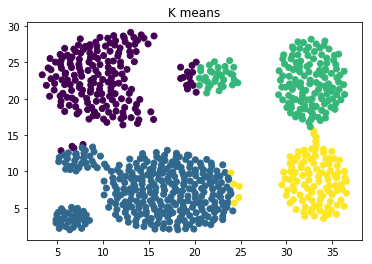

In [88]:
dn = 'Aggregation'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
result = run_k_means(data,labels,n_cluster_range)

### Compound

n_clusters  2 silhouette score: 0.638322701273 0.674800765167 rand_score: 0.436616736387
n_clusters  3 silhouette score: 0.575599408041 0.577302364115 rand_score: 0.740208347351
n_clusters  4 silhouette score: 0.499700924267 0.536003004117 rand_score: 0.533226113221
n_clusters  5 silhouette score: 0.524247024474 0.582748010555 rand_score: 0.580236175342
n_clusters  6 silhouette score: 0.431711530162 0.456831173312 rand_score: 0.537865257476
n_clusters  7 silhouette score: 0.431298009925 0.482593315533 rand_score: 0.539861807184
n_clusters  8 silhouette score: 0.429609217196 0.464604778991 rand_score: 0.477394740329
n_clusters  9 silhouette score: 0.416616437709 0.452962249373 rand_score: 0.440648115875
n_clusters  10 silhouette score: 0.444515702039 0.483392284871 rand_score: 0.427954706906
Best n_clusters 2 2
adjusted_rand_score 0.436616736387


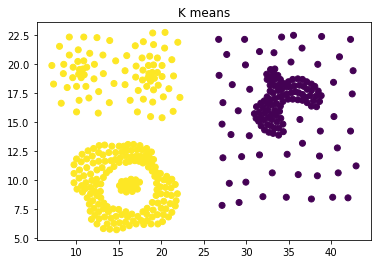

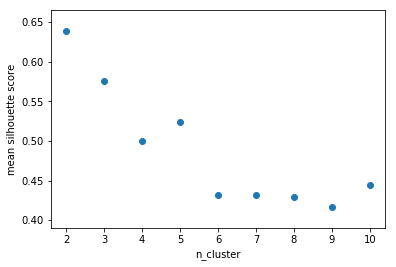

In [102]:
dn = 'Compound'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
result = run_k_means(data,labels,n_cluster_range)

### D31

n_clusters  26 silhouette score: 0.529799738741 0.576106907476 rand_score: 0.790225739137
n_clusters  27 silhouette score: 0.548834472518 0.602729981244 rand_score: 0.827251295852
n_clusters  28 silhouette score: 0.55277953027 0.604787788443 rand_score: 0.860162918414
n_clusters  29 silhouette score: 0.559830177523 0.610219607108 rand_score: 0.883366396608
n_clusters  30 silhouette score: 0.54370638948 0.601109628985 rand_score: 0.866892977183
n_clusters  31 silhouette score: 0.546724785903 0.597434975359 rand_score: 0.906015334136
n_clusters  32 silhouette score: 0.545809189847 0.59546429716 rand_score: 0.900290293995
n_clusters  33 silhouette score: 0.536213725115 0.587517371345 rand_score: 0.891263140171
n_clusters  34 silhouette score: 0.557838814997 0.607120612311 rand_score: 0.931158211238
n_clusters  35 silhouette score: 0.535437226701 0.586202599611 rand_score: 0.917745216482
Best n_clusters 29 29
adjusted_rand_score 0.883366396608


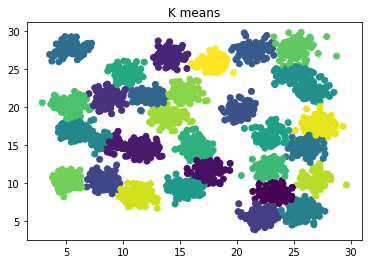

In [90]:
dn = 'D31'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
result = run_k_means(data,labels,n_cluster_range)

### flame

n_clusters  2 silhouette score: 0.37849407108 0.41754763656
n_clusters  3 silhouette score: 0.412065681742 0.456569444431
n_clusters  4 silhouette score: 0.442601197384 0.49251922981
n_clusters  5 silhouette score: 0.402699654904 0.455129035393
n_clusters  6 silhouette score: 0.384810497714 0.418465039178
Best n_clusters 4 4
adjusted_rand_score 0.429673171496


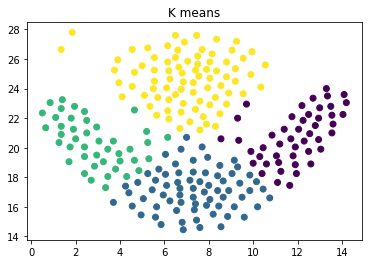

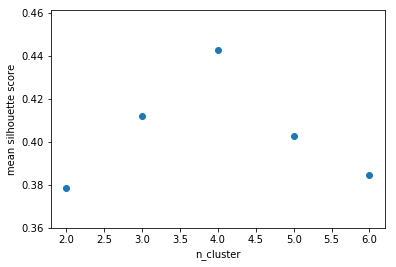

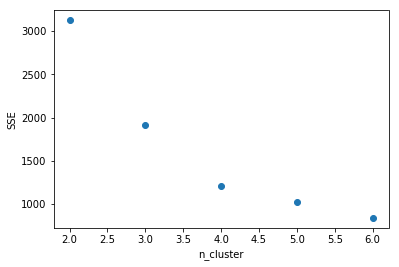

In [105]:
dn = 'flame'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
result = run_k_means(data,labels,n_cluster_range)

### jain

n_clusters  2 silhouette score: 0.495231110817 0.545639355278
n_clusters  3 silhouette score: 0.486591077677 0.544732514131
n_clusters  4 silhouette score: 0.480115409231 0.520834125775
n_clusters  5 silhouette score: 0.462613417781 0.50324051502
n_clusters  6 silhouette score: 0.483299613624 0.531194027696
Best n_clusters 2 2
adjusted_rand_score 0.324108044612


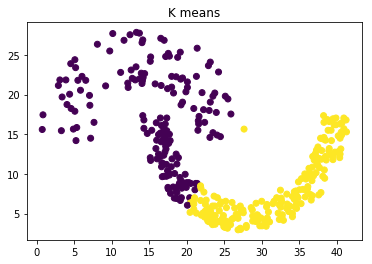

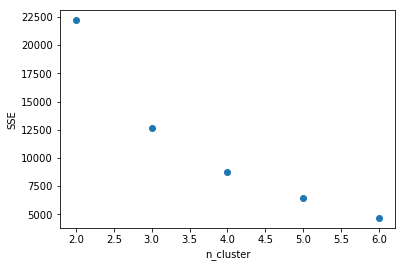

In [106]:
dn = 'jain'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
result = run_k_means(data,labels,n_cluster_range)

### pathbased

n_clusters  2 silhouette score: 0.515012304404 0.559500253106
n_clusters  3 silhouette score: 0.541921855722 0.58814396557
n_clusters  4 silhouette score: 0.43406939221 0.460003558401
n_clusters  5 silhouette score: 0.382572572754 0.434585596824
n_clusters  6 silhouette score: 0.378388424221 0.416415192083
n_clusters  7 silhouette score: 0.410515204497 0.441532548171
Best n_clusters 3 3
adjusted_rand_score 0.461328934865


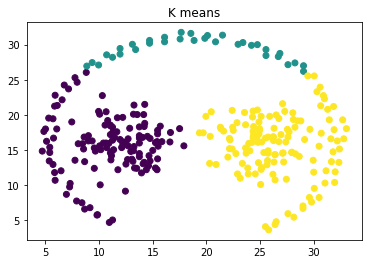

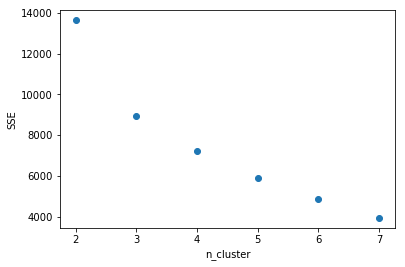

In [107]:
dn = 'pathbased'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
result = run_k_means(data,labels,n_cluster_range)

### R15

n_clusters  10 silhouette score: 0.639831402842 0.62236535629


/home/chvlyl/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice.


n_clusters  11 silhouette score: -1 -1.0
n_clusters  12 silhouette score: 0.66771506719 0.689301210895
n_clusters  13 silhouette score: -1 -1.0
n_clusters  14 silhouette score: -1 -1.0
n_clusters  15 silhouette score: -1 -1.0
n_clusters  16 silhouette score: -1 -1.0
n_clusters  17 silhouette score: -1 -1.0
n_clusters  18 silhouette score: -1 -1.0
n_clusters  19 silhouette score: -1 -1.0
Best n_clusters 12 12
adjusted_rand_score 0.792308234145


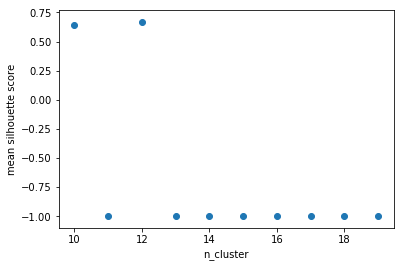

In [109]:
dn = 'R15'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
result = run_k_means(data,labels,n_cluster_range)

### spiral

n_clusters  2 silhouette score: 0.347980364817 0.371890238324
n_clusters  3 silhouette score: 0.360070826206 0.409561517091
n_clusters  4 silhouette score: 0.354688021489 0.38092603478
n_clusters  5 silhouette score: 0.348315687865 0.366574212585
n_clusters  6 silhouette score: 0.351446958922 0.387918620717
n_clusters  7 silhouette score: 0.355208829906 0.380046498032
Best n_clusters 3 3
adjusted_rand_score -0.00603028578959


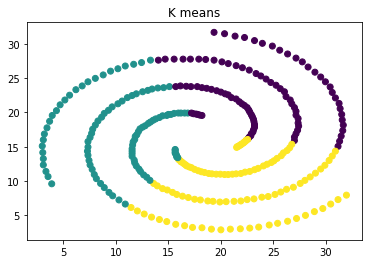

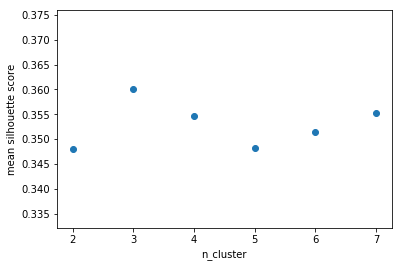

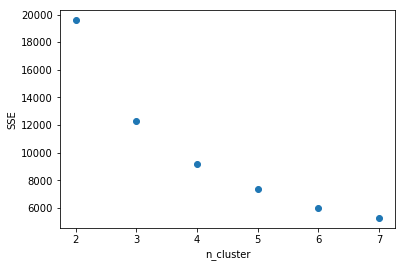

In [110]:
dn = 'spiral'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
result = run_k_means(data,labels,n_cluster_range)

### --- Real data --

### letter

n_clusters  21 silhouette score: 0.14468059987 0.131403399688
n_clusters  22 silhouette score: 0.143862053283 0.134571943288
n_clusters  23 silhouette score: 0.147933988246 0.137730288069
n_clusters  24 silhouette score: 0.148190159586 0.135977416684
n_clusters  25 silhouette score: 0.152639856014 0.138994218116
n_clusters  26 silhouette score: 0.148894766101 0.132822593698


/home/chvlyl/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice.


n_clusters  27 silhouette score: -1 -1.0
n_clusters  28 silhouette score: 0.149800478949 0.136794761813
n_clusters  29 silhouette score: 0.150130964294 0.133765002864
n_clusters  30 silhouette score: 0.153973930027 0.139326007137
Best n_clusters 30 30
adjusted_rand_score 0.134941042313


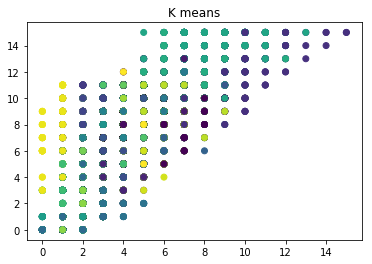

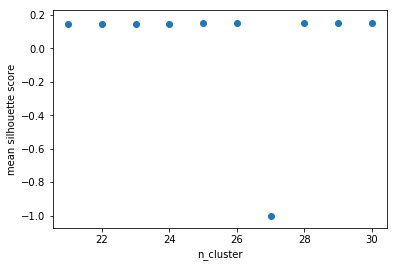

In [112]:
dn = 'letter'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
### too slow, only test smaller range
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-3),true_n_clusters+3)
result = run_k_means(data,labels,n_cluster_range)

### wine

n_clusters  2 silhouette score: 0.298722181597 0.336976292233
n_clusters  3 silhouette score: 0.30134632735 0.332743665856
n_clusters  4 silhouette score: 0.259936675616 0.281920615826
n_clusters  5 silhouette score: 0.242280555267 0.253290977312
n_clusters  6 silhouette score: 0.215388444176 0.223583736949
n_clusters  7 silhouette score: 0.210158377349 0.195052945966
Best n_clusters 3 2
adjusted_rand_score 0.86854254932


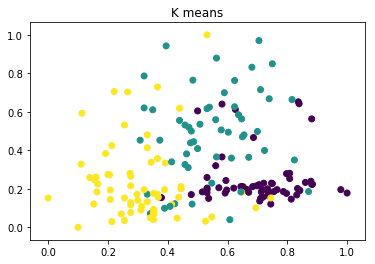

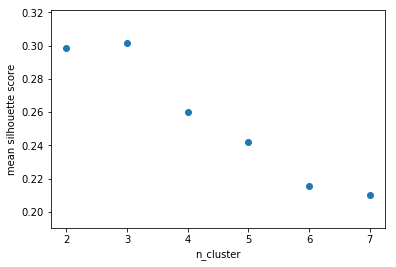

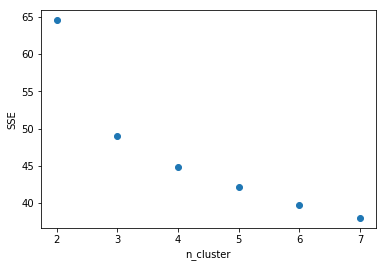

In [116]:
dn = 'wine'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
result = run_k_means(data,labels,n_cluster_range)

### glass

n_clusters  2 silhouette score: 0.560027036171 0.701598738298
n_clusters  3 silhouette score: 0.582242951617 0.675196286019
n_clusters  4 silhouette score: 0.587948576186 0.671828635092
n_clusters  5 silhouette score: 0.447241067108 0.548736870628
n_clusters  6 silhouette score: 0.451978534108 0.531598172714
n_clusters  7 silhouette score: 0.46026275935 0.541046297873
n_clusters  8 silhouette score: 0.286896171714 0.285426371464
n_clusters  9 silhouette score: 0.3041441405 0.292498250147
n_clusters  10 silhouette score: 0.300180861095 0.302716433861
Best n_clusters 4 2
adjusted_rand_score 0.251967538579


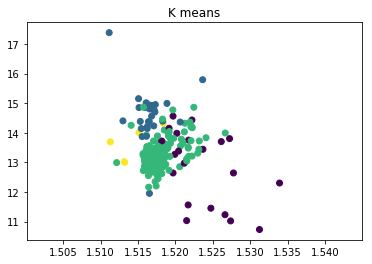

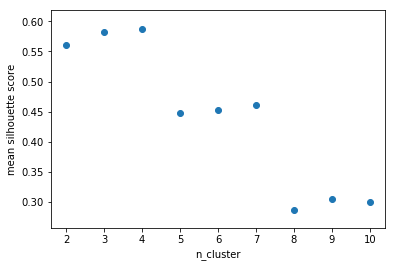

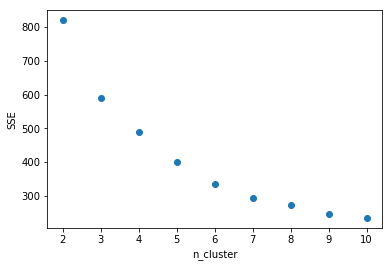

In [117]:
dn = 'glass'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
result = run_k_means(data,labels,n_cluster_range)

### thyroid

n_clusters  2 silhouette score: 0.585208381731 0.638218842897
n_clusters  3 silhouette score: 0.562425824536 0.643341220389
n_clusters  4 silhouette score: 0.304742768238 0.300343178007
n_clusters  5 silhouette score: 0.31909242562 0.323264569044
n_clusters  6 silhouette score: 0.316365643636 0.337949009275
Best n_clusters 2 3
adjusted_rand_score 0.232672607337


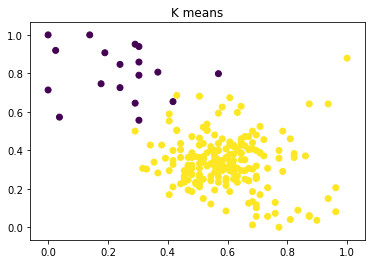

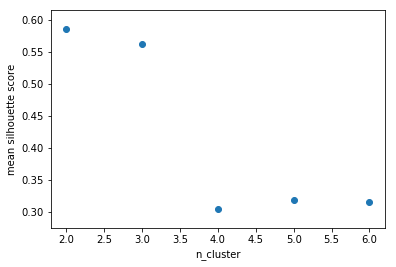

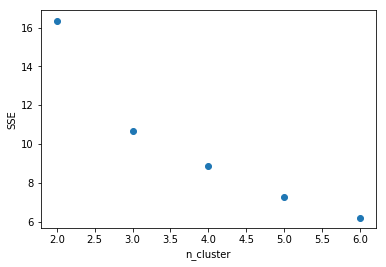

In [118]:
dn = 'thyroid'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
result = run_k_means(data,labels,n_cluster_range)

### yeast

n_clusters  5 silhouette score: 0.27503674295 0.290917853981
n_clusters  6 silhouette score: 0.215563671815 0.214831351072
n_clusters  7 silhouette score: 0.202934848521 0.203024944738
n_clusters  8 silhouette score: 0.181373018414 0.174320927187
n_clusters  9 silhouette score: 0.183083128989 0.17688523188
n_clusters  10 silhouette score: 0.171662272254 0.168664691947
n_clusters  11 silhouette score: 0.17398318071 0.17439473538
n_clusters  12 silhouette score: 0.170081921149 0.161090012173
n_clusters  13 silhouette score: 0.178770298971 0.178136168396


/home/chvlyl/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice.


n_clusters  14 silhouette score: -1 -1.0
Best n_clusters 5 5
adjusted_rand_score 0.129524642903


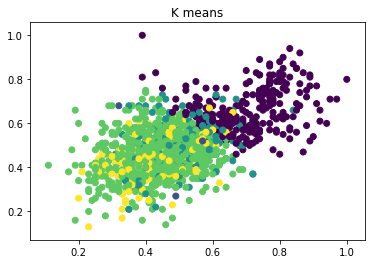

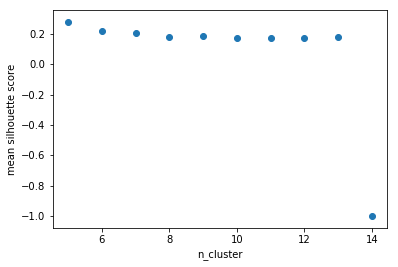

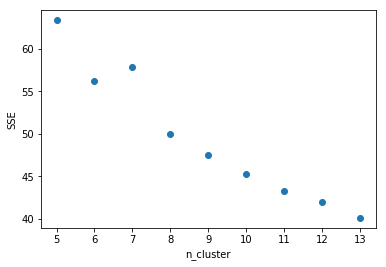

In [119]:
dn = 'yeast'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
result = run_k_means(data,labels,n_cluster_range)

### iris

n_clusters  2 silhouette score: 0.629467556191 0.651146350045
n_clusters  3 silhouette score: 0.504318854915 0.519822387534
n_clusters  4 silhouette score: 0.444627330065 0.435629067382
n_clusters  5 silhouette score: 0.353739369613 0.362522415965
n_clusters  6 silhouette score: 0.350381355794 0.365468167609


/home/chvlyl/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice.


n_clusters  7 silhouette score: -1 -1.0
Best n_clusters 2 2
adjusted_rand_score 0.568115942029


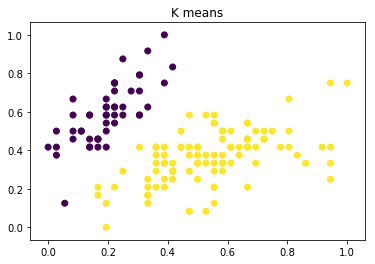

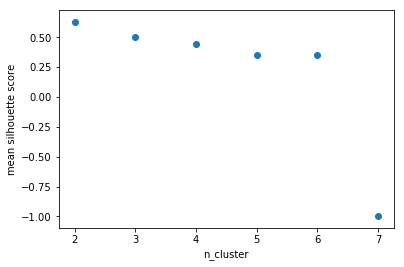

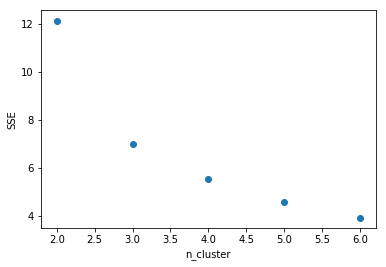

In [120]:
dn = 'iris'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
result = run_k_means(data,labels,n_cluster_range)

### leaves

n_clusters  97 silhouette score: 0.192026016518 0.180160231061
n_clusters  98 silhouette score: 0.198754977085 0.186012768147
n_clusters  99 silhouette score: 0.20212237061 0.191013784237
n_clusters  100 silhouette score: 0.18937684007 0.170601370754
n_clusters  101 silhouette score: 0.196585090379 0.186834275927
n_clusters  102 silhouette score: 0.193863382841 0.177013308587
Best n_clusters 99 99
adjusted_rand_score 0.296728155428


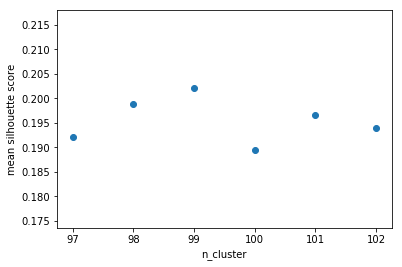

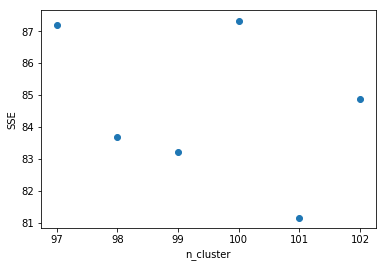

In [122]:
dn = 'leaves'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-3),true_n_clusters+3)
result = run_k_means(data,labels,n_cluster_range)

### wdbc

n_clusters  2 silhouette score: 0.384549488349 0.418631647659
n_clusters  3 silhouette score: 0.333593115368 0.349273616543
n_clusters  4 silhouette score: 0.316162089029 0.347098070381
n_clusters  5 silhouette score: 0.169196539603 0.164007857128
n_clusters  6 silhouette score: 0.154682152653 0.161646414447
Best n_clusters 2 2
adjusted_rand_score 0.730174902761


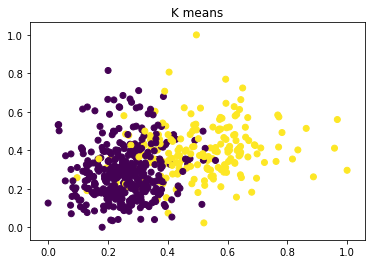

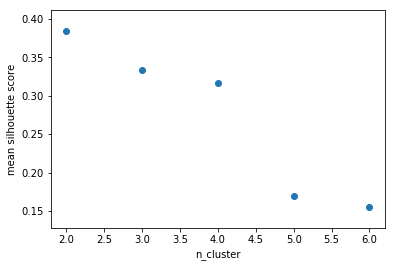

In [123]:
dn = 'wdbc'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
result = run_k_means(data,labels,n_cluster_range)

## Kernel K means

### --- Simulated data ---

### Aggregation

Sigma 1.0
n_clusters  2 silhouette score: 0.218017632441 0.206610478745 rand_score: 0.27020119684
n_clusters  3 silhouette score: 0.171526374575 0.342252915022 rand_score: 0.274536367957
n_clusters  4 silhouette score: 0.0917253249204 0.137479455357 rand_score: 0.374009119566
n_clusters  5 silhouette score: 0.114069413829 0.14532707523 rand_score: 0.269232023832
n_clusters  6 silhouette score: -0.0487480868938 -0.133006350857 rand_score: 0.235457654579
n_clusters  7 silhouette score: 0.00528758697536 -0.0464063296958 rand_score: 0.327832424496
n_clusters  8 silhouette score: 0.0805165808168 0.200928806272 rand_score: 0.342271256016
n_clusters  9 silhouette score: -0.0222270871454 -0.0595464808876 rand_score: 0.288123817145
n_clusters  10 silhouette score: -0.0494157456206 -0.154408474045 rand_score: 0.216694435051
n_clusters  11 silhouette score: 0.057045667344 0.112870770376 rand_score: 0.328127507834
Best n_clusters 2 3
adjusted_rand_score 0.27020119684


Sigma 2.0
n_clusters  2 silhouette score: 0.236738788165 0.20114868445 rand_score: 0.364458116727
n_clusters  3 silhouette score: 0.457806352621 0.531266955889 rand_score: 0.700091445606
n_clusters  4 silhouette score: 0.397966692093 0.565992215747 rand_score: 0.851649645585
n_clusters  5 silhouette score: 0.35620124819 0.468851447142 rand_score: 0.66810927577
n_clusters  6 silhouette score: 0.348771991599 0.441100769158 rand_score: 0.74600853397
n_clusters  7 silhouette score: 0.449649963022 0.523230525271 rand_score: 0.781845809126
n_clusters  8 silhouette score: 0.375422175005 0.50999306369 rand_score: 0.649018621188
n_clusters  9 silhouette score: 0.403429567662 0.523903271161 rand_score: 0.598949045359
n_clusters  10 silhouette score: 0.345913094402 0.432853152027 rand_score: 0.559380560872
n_clusters  11 silhouette score: 0.413418620749 0.43644148321 rand_score: 0.51147607868
Best n_clusters 3 4
adjusted_rand_score 0.700091445606


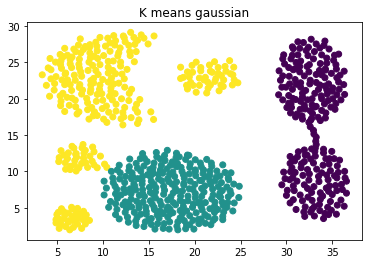

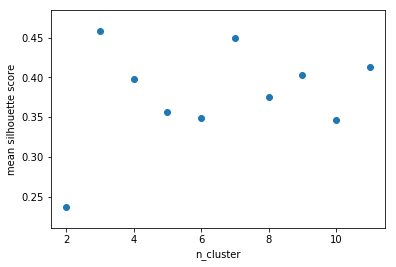

Sigma 3.0
n_clusters  2 silhouette score: 0.236738788165 0.20114868445 rand_score: 0.364458116727
n_clusters  3 silhouette score: 0.459624547084 0.550221858124 rand_score: 0.702466286773
n_clusters  4 silhouette score: 0.405308993182 0.613911979237 rand_score: 0.847558261601
n_clusters  5 silhouette score: 0.428050642953 0.484872420139 rand_score: 0.676158648185
n_clusters  6 silhouette score: 0.414580913926 0.533466861783 rand_score: 0.754543658214
n_clusters  7 silhouette score: 0.483705054331 0.508174623386 rand_score: 0.78517431624
n_clusters  8 silhouette score: 0.454769219946 0.47626421264 rand_score: 0.694580164325


/home/chvlyl/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice.


n_clusters  9 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  10 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  11 silhouette score: -1 -1.0 rand_score: 0.0
Best n_clusters 7 4
adjusted_rand_score 0.78517431624


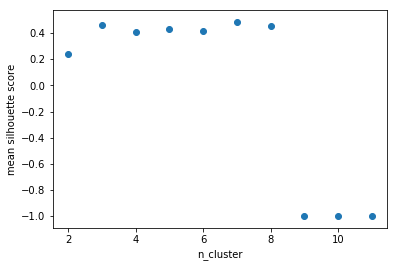

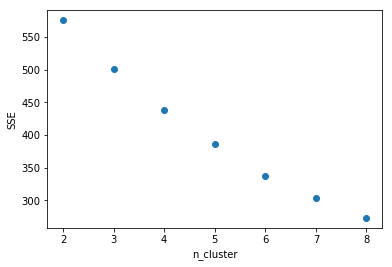

Sigma 5.0
n_clusters  2 silhouette score: 0.349736360413 0.383829356123 rand_score: 0.421734689062
n_clusters  3 silhouette score: 0.523614697316 0.558640982048 rand_score: 0.683174208851
n_clusters  4 silhouette score: 0.523183013666 0.577574000921 rand_score: 0.783150586404
n_clusters  5 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  6 silhouette score: 0.508567784273 0.540699219149 rand_score: 0.786975709308
n_clusters  7 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  8 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  9 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  10 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  11 silhouette score: -1 -1.0 rand_score: 0.0
Best n_clusters 3 4
adjusted_rand_score 0.683174208851


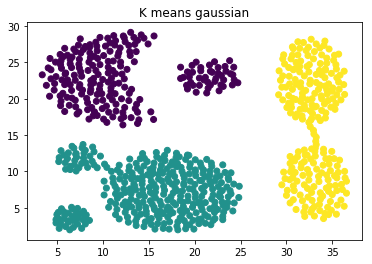

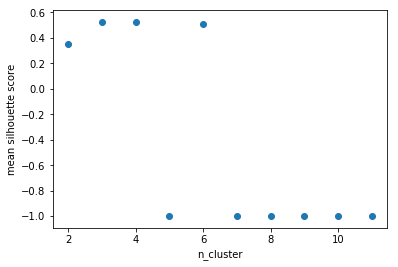

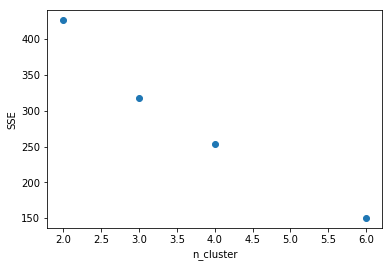

In [75]:
dn = 'Aggregation'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
for sigma in [1.0,2.0,3.0,5.0]:
    print("==================================")
    print("Sigma",sigma)
    result = run_k_means(data,labels,n_cluster_range,kernel='gaussian',sigma=sigma)

### Compound

Sigma 1.0
n_clusters  2 silhouette score: 0.437151245032 0.547641385636
n_clusters  3 silhouette score: 0.0441791411601 -0.216232342765
n_clusters  4 silhouette score: -0.0202036400103 -0.129983496682
n_clusters  5 silhouette score: 0.0622487564726 -0.0420855508021
n_clusters  6 silhouette score: 0.03042043826 -0.015115554053
n_clusters  7 silhouette score: 0.0640736663057 0.194824630524
n_clusters  8 silhouette score: 0.0963862435657 0.201324446151
n_clusters  9 silhouette score: 0.0892177623357 0.343373674734
n_clusters  10 silhouette score: 0.0670343435578 0.321963817456
Best n_clusters 2 2
adjusted_rand_score 0.306928990617


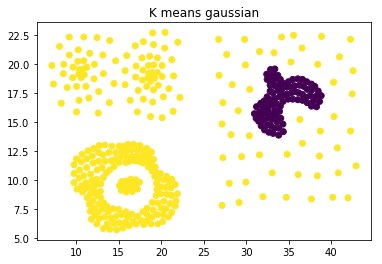

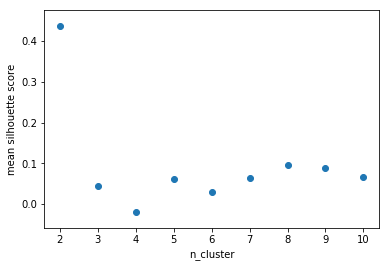

Sigma 2.0
n_clusters  2 silhouette score: 0.417299007796 0.514468915472
n_clusters  3 silhouette score: 0.270452160593 0.610521336244
n_clusters  4 silhouette score: 0.290173870318 0.435878114634
n_clusters  5 silhouette score: 0.263478670849 0.409393501232
n_clusters  6 silhouette score: 0.18407713616 0.327044413835
n_clusters  7 silhouette score: 0.243011675725 0.4272010415
n_clusters  8 silhouette score: 0.251997142059 0.441079705062
n_clusters  9 silhouette score: 0.366221560395 0.486370014469
n_clusters  10 silhouette score: 0.373189617335 0.490659130847
Best n_clusters 2 3
adjusted_rand_score 0.484127176232


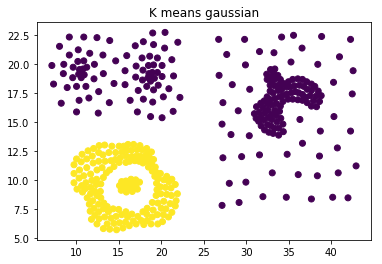

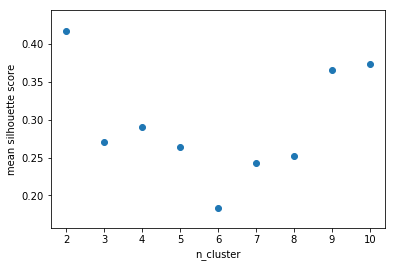

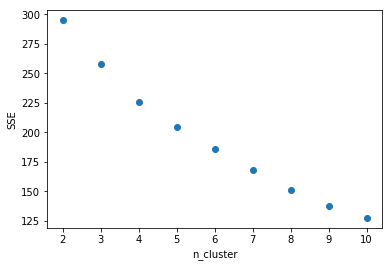

Sigma 3.0
n_clusters  2 silhouette score: 0.417299007796 0.514468915472
n_clusters  3 silhouette score: 0.459975901411 0.626616082882
n_clusters  4 silhouette score: 0.351995028309 0.479228197829
n_clusters  5 silhouette score: 0.36312444371 0.553195975933
n_clusters  6 silhouette score: 0.382942297044 0.510439883169


/home/chvlyl/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice.


n_clusters  7 silhouette score: -1 -1.0
n_clusters  8 silhouette score: -1 -1.0
n_clusters  9 silhouette score: -1 -1.0
n_clusters  10 silhouette score: -1 -1.0
Best n_clusters 3 3
adjusted_rand_score 0.728992157762


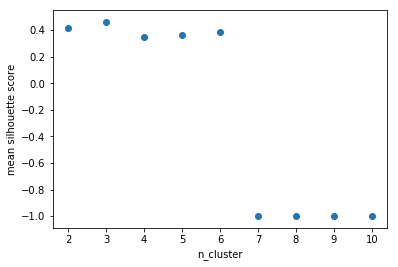

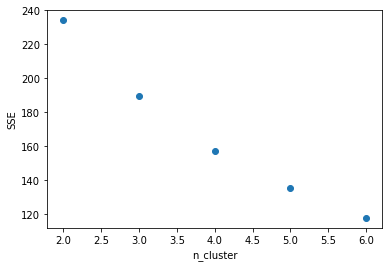

Sigma 5.0
n_clusters  2 silhouette score: 0.638138271929 0.675566610921
n_clusters  3 silhouette score: 0.575599408041 0.577302364115
n_clusters  4 silhouette score: 0.501753552686 0.535964067805
n_clusters  5 silhouette score: -1 -1.0
n_clusters  6 silhouette score: -1 -1.0
n_clusters  7 silhouette score: -1 -1.0
n_clusters  8 silhouette score: -1 -1.0
n_clusters  9 silhouette score: -1 -1.0
n_clusters  10 silhouette score: -1 -1.0
Best n_clusters 2 2
adjusted_rand_score 0.432243745219


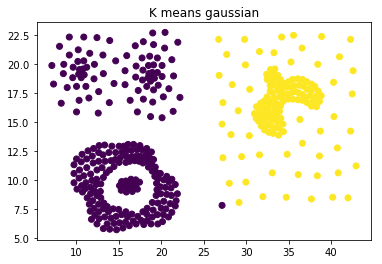

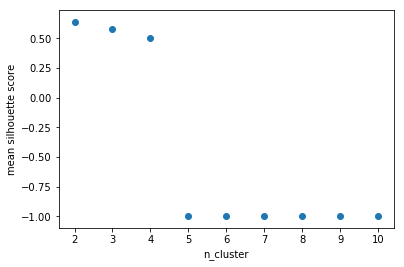

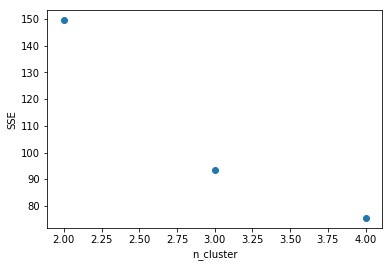

In [131]:
dn = 'Compound'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
for sigma in [1.0,2.0,3.0,5.0]:
    print("==================================")
    print("Sigma",sigma)
    result = run_k_means(data,labels,n_cluster_range,kernel='gaussian',sigma=sigma)

### D31

Sigma 1.0
Use best K means centroid
n_clusters  26 silhouette score: 0.13100257577 0.528641925799 rand_score: 0.709211713887
Use best K means centroid
n_clusters  27 silhouette score: 0.327611862869 0.577004633707 rand_score: 0.801369916797
Use best K means centroid
n_clusters  28 silhouette score: 0.345699954084 0.576268336426 rand_score: 0.800401146366
Use best K means centroid
n_clusters  29 silhouette score: 0.332111275132 0.545702714631 rand_score: 0.795256198908
Use best K means centroid
n_clusters  30 silhouette score: 0.298111955415 0.574911280294 rand_score: 0.719194714386
Use best K means centroid
n_clusters  31 silhouette score: 0.333426438625 0.577788593103 rand_score: 0.75411975497
Use best K means centroid
n_clusters  32 silhouette score: 0.402144023337 0.56786350043 rand_score: 0.830058990127
Use best K means centroid
n_clusters  33 silhouette score: 0.337575119017 0.591526970519 rand_score: 0.756413424056
Use best K means centroid
n_clusters  34 silhouette score: 0.2073

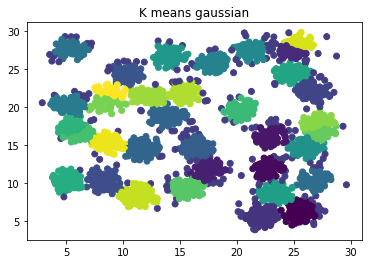

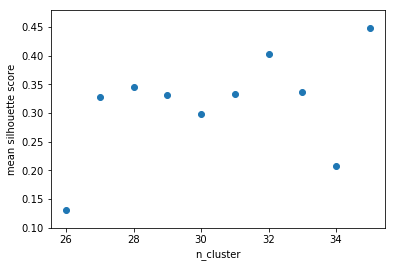

Sigma 2.0
Use best K means centroid
n_clusters  26 silhouette score: 0.314996825431 0.500418065555 rand_score: 0.75998453034
Use best K means centroid


/home/chvlyl/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice.
/home/chvlyl/anaconda2/envs/python3/lib/python3.5/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/chvlyl/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/chvlyl/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars


n_clusters  27 silhouette score: -1 -1.0 rand_score: 0.0
Use best K means centroid
n_clusters  28 silhouette score: 0.324448696056 0.567841574522 rand_score: 0.827343449881
Use best K means centroid
n_clusters  29 silhouette score: 0.379308238846 0.523574068001 rand_score: 0.769426466832
Use best K means centroid
n_clusters  30 silhouette score: -1 -1.0 rand_score: 0.0
Use best K means centroid
n_clusters  31 silhouette score: -1 -1.0 rand_score: 0.0
Use best K means centroid
n_clusters  32 silhouette score: 0.549745568639 0.601867299934 rand_score: 0.90871571146
Use best K means centroid


KeyboardInterrupt: 

In [247]:
dn = 'D31'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
for sigma in [1.0,2.0,3.0,5.0]:
    print("==================================")
    print("Sigma",sigma)
    result = run_k_means(data,labels,n_cluster_range,n_init = 1,sigma = sigma,kernel='gaussian',
                         use_kmean_controid=True)

### flame

Sigma 1.0
n_clusters  2 silhouette score: 0.321753664743 0.379903713229
n_clusters  3 silhouette score: 0.301371996114 0.466067734761
n_clusters  4 silhouette score: 0.34310391146 0.434524165233
n_clusters  5 silhouette score: 0.316903839342 0.446473637552
n_clusters  6 silhouette score: 0.337863847094 0.401943328637
Best n_clusters 4 3
adjusted_rand_score 0.229049672276


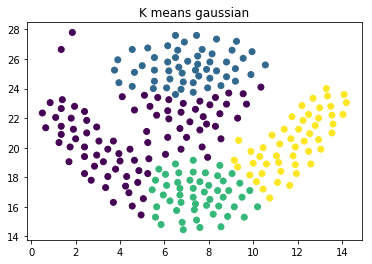

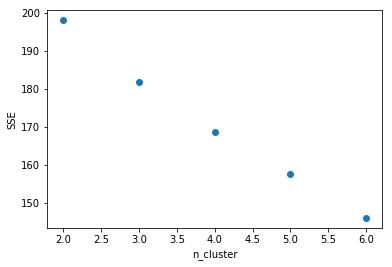

Sigma 2.0
n_clusters  2 silhouette score: 0.323822578143 0.382484898162
n_clusters  3 silhouette score: 0.406510630589 0.463298627401
n_clusters  4 silhouette score: 0.442618663395 0.495617201484
n_clusters  5 silhouette score: 0.402630074493 0.4511798327
n_clusters  6 silhouette score: 0.38085862263 0.413784379136
Best n_clusters 4 4
adjusted_rand_score 0.463567505224


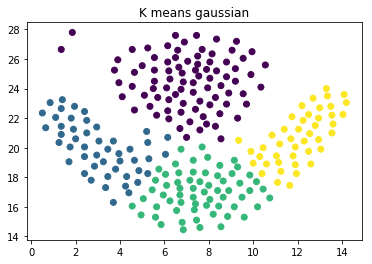

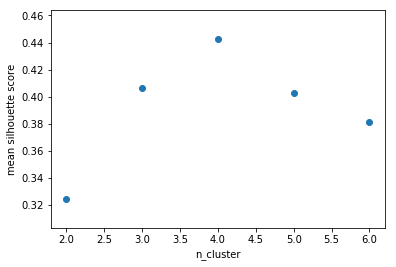

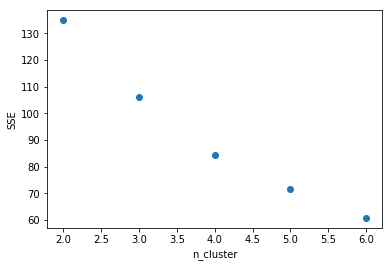

Sigma 3.0
n_clusters  2 silhouette score: 0.378717443856 0.416506310092
n_clusters  3 silhouette score: 0.416710102659 0.464883570103
n_clusters  4 silhouette score: 0.443951876069 0.496251023305
n_clusters  5 silhouette score: 0.403543961353 0.455854258188


/home/chvlyl/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice.


n_clusters  6 silhouette score: -1 -1.0
Best n_clusters 4 4
adjusted_rand_score 0.455961068856


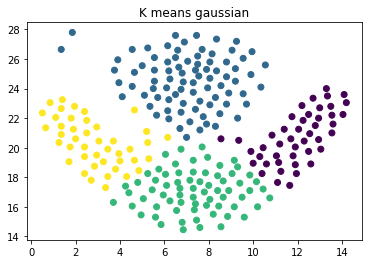

Sigma 5.0
n_clusters  2 silhouette score: 0.378687283053 0.41671580633
n_clusters  3 silhouette score: 0.410531931394 0.451742526389
n_clusters  4 silhouette score: -1 -1.0
n_clusters  5 silhouette score: -1 -1.0
n_clusters  6 silhouette score: -1 -1.0
Best n_clusters 3 3
adjusted_rand_score 0.549593450816


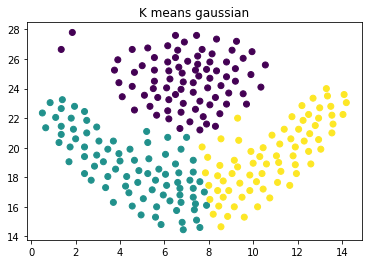

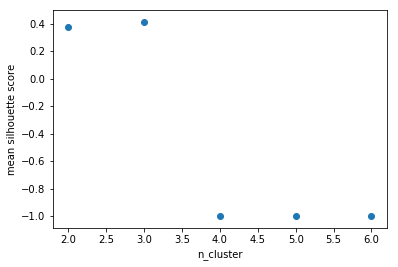

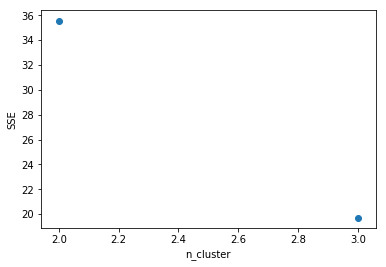

In [133]:
dn = 'flame'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
for sigma in [1.0,2.0,3.0,5.0]:
    print("==================================")
    print("Sigma",sigma)
    result = run_k_means(data,labels,n_cluster_range,kernel='gaussian',sigma=sigma)

### jain

Sigma 1.0
n_clusters  2 silhouette score: 0.0790227101626 0.0724539694105
n_clusters  3 silhouette score: 0.0537344306812 0.146842403509
n_clusters  4 silhouette score: -0.0171026534757 0.00265985445139
n_clusters  5 silhouette score: -0.0380151245598 -0.0513038977624
n_clusters  6 silhouette score: 0.041412077333 -0.111015614468
Best n_clusters 2 3
adjusted_rand_score -0.0272580843288


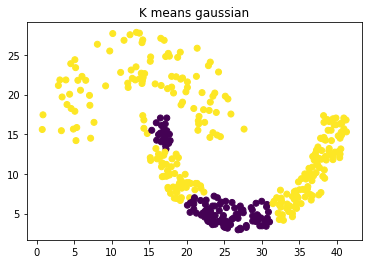

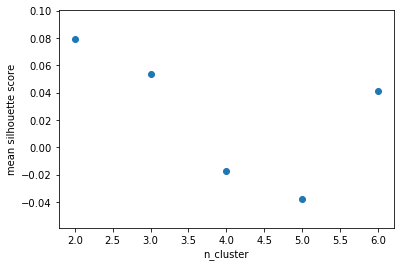

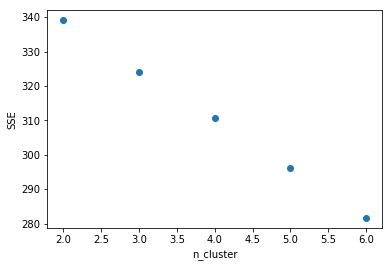

Sigma 2.0
n_clusters  2 silhouette score: 0.20756282093 0.225593522072
n_clusters  3 silhouette score: 0.192621553415 0.195204536487
n_clusters  4 silhouette score: 0.439625062801 0.506658491547
n_clusters  5 silhouette score: 0.401112738587 0.468333408741
n_clusters  6 silhouette score: 0.388729500976 0.444509228329
Best n_clusters 4 4
adjusted_rand_score 0.129215927213


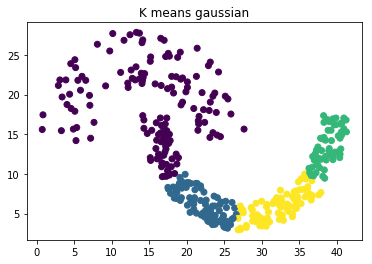

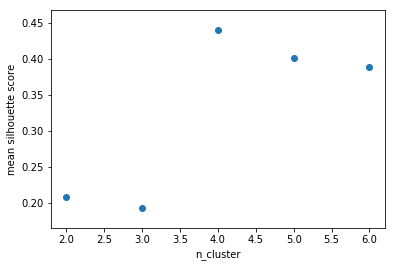

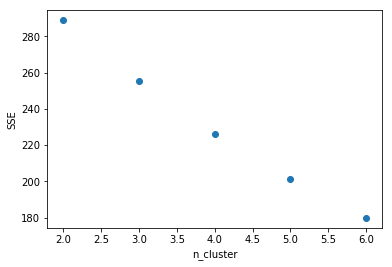

Sigma 3.0
n_clusters  2 silhouette score: 0.463441026028 0.513458642449
n_clusters  3 silhouette score: 0.450749467215 0.529041350996
n_clusters  4 silhouette score: 0.429219690454 0.492945712077
n_clusters  5 silhouette score: 0.425171593361 0.446867732072
n_clusters  6 silhouette score: 0.390361353355 0.442018704193
Best n_clusters 2 3
adjusted_rand_score 0.0278552995961


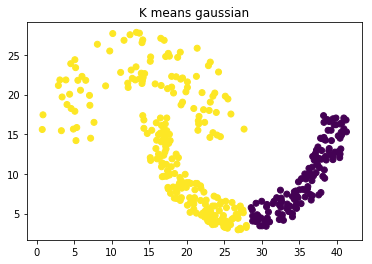

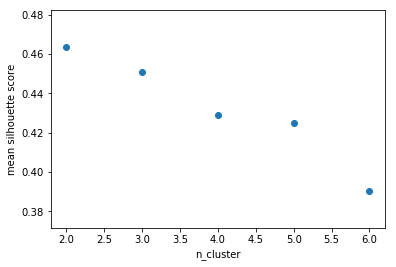

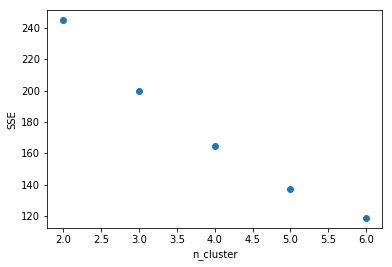

Sigma 5.0
n_clusters  2 silhouette score: 0.492969265057 0.542105048465
n_clusters  3 silhouette score: 0.485371753131 0.533099118943


/home/chvlyl/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice.


n_clusters  4 silhouette score: -1 -1.0
n_clusters  5 silhouette score: -1 -1.0
n_clusters  6 silhouette score: -1 -1.0
Best n_clusters 2 2
adjusted_rand_score 0.260669231523


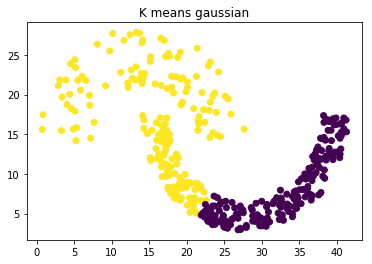

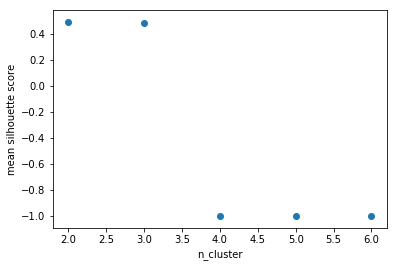

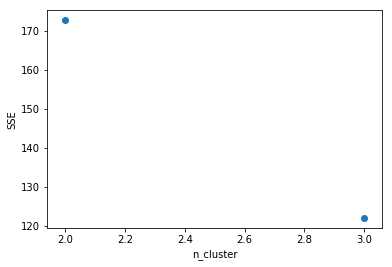

In [134]:
dn = 'jain'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
for sigma in [1.0,2.0,3.0,5.0]:
    print("==================================")
    print("Sigma",sigma)
    result = run_k_means(data,labels,n_cluster_range,kernel='gaussian',sigma=sigma)

### pathbased

Sigma 1.0
n_clusters  2 silhouette score: 0.160781140971 0.235490773798
n_clusters  3 silhouette score: -0.143224759104 -0.298949786834
n_clusters  4 silhouette score: -0.109237582287 -0.232625289649
n_clusters  5 silhouette score: -0.0838547673542 -0.223336325076
n_clusters  6 silhouette score: -0.230296049042 -0.452178114771
n_clusters  7 silhouette score: -0.261501227194 -0.469314805666
Best n_clusters 2 2
adjusted_rand_score 0.291271591856


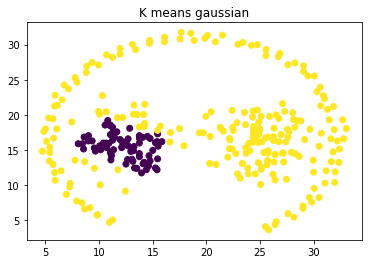

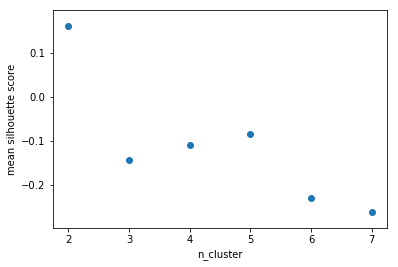

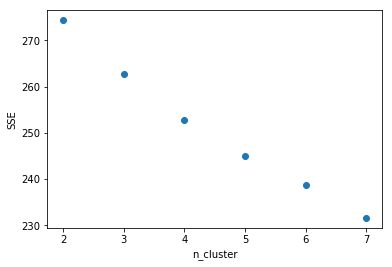

Sigma 2.0
n_clusters  2 silhouette score: 0.218008605558 0.261969537995
n_clusters  3 silhouette score: 0.173828455776 0.575263966135
n_clusters  4 silhouette score: 0.0579764532189 0.166120659265
n_clusters  5 silhouette score: -0.0102070221109 0.131271102595
n_clusters  6 silhouette score: 0.00660823660221 0.0936322746062
n_clusters  7 silhouette score: 0.0831777882772 0.216032031891
Best n_clusters 2 3
adjusted_rand_score 0.435864182209


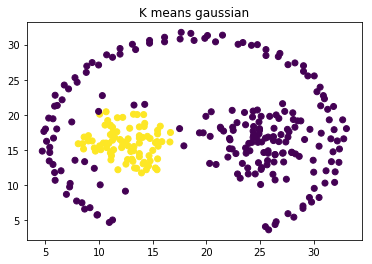

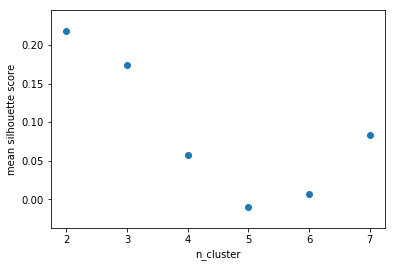

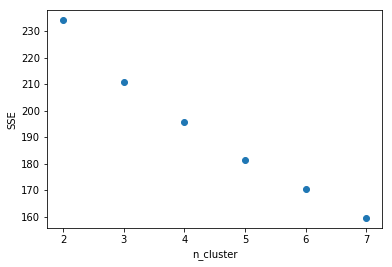

Sigma 3.0
n_clusters  2 silhouette score: 0.25176665791 0.296014138408
n_clusters  3 silhouette score: 0.24779844755 0.577522414107
n_clusters  4 silhouette score: 0.227465637942 0.38178462082
n_clusters  5 silhouette score: 0.315699452195 0.374378550673
n_clusters  6 silhouette score: 0.270843576332 0.338299888612
n_clusters  7 silhouette score: 0.18630872293 0.298359346
Best n_clusters 5 3
adjusted_rand_score 0.520628223482


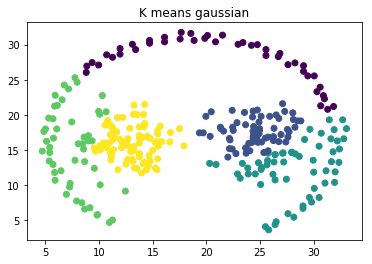

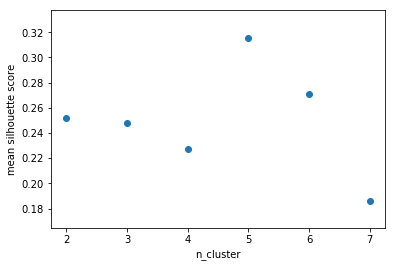

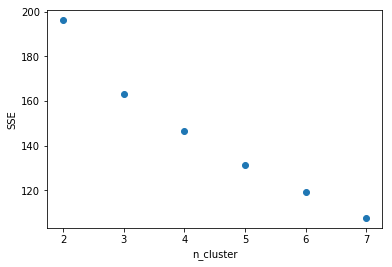

Sigma 5.0
n_clusters  2 silhouette score: 0.493278667743 0.54109651413
n_clusters  3 silhouette score: 0.421959111193 0.603495400024


/home/chvlyl/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice.


n_clusters  4 silhouette score: -1 -1.0
n_clusters  5 silhouette score: -1 -1.0
n_clusters  6 silhouette score: -1 -1.0
n_clusters  7 silhouette score: -1 -1.0
Best n_clusters 2 3
adjusted_rand_score 0.414434076996


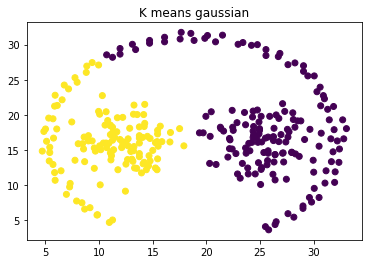

In [135]:
dn = 'pathbased'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
for sigma in [1.0,2.0,3.0,5.0]:
    print("==================================")
    print("Sigma",sigma)
    result = run_k_means(data,labels,n_cluster_range,kernel='gaussian',sigma=sigma)

### R15

Sigma 1.0


/home/chvlyl/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice.


n_clusters  10 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  11 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  12 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  13 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  14 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  15 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  16 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  17 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  18 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  19 silhouette score: -1 -1.0 rand_score: 0.0
Best n_clusters 10 10
adjusted_rand_score 0.0


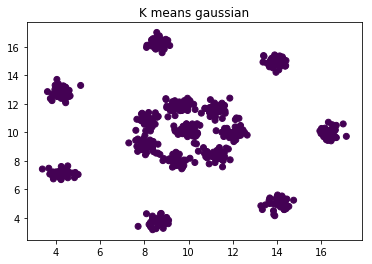

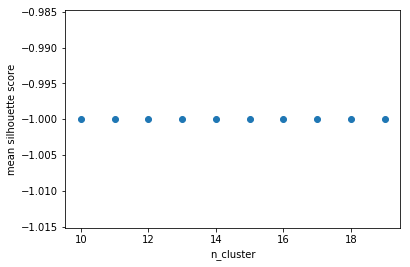

Sigma 2.0
n_clusters  10 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  11 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  12 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  13 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  14 silhouette score: -1 -1.0 rand_score: 0.0


KeyboardInterrupt: 

In [138]:
dn = 'R15'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
for sigma in [1.0,2.0,3.0,5.0]:
    print("==================================")
    print("Sigma",sigma)
    result = run_k_means(data,labels,n_cluster_range,n_init = 1,sigma = sigma,kernel='gaussian',
                         use_kmean_controid=True)

### spiral

Sigma 1.0
n_clusters  2 silhouette score: -0.131090285895 -0.207414023375 rand_score: 0.0105708742049
n_clusters  3 silhouette score: -0.208461639334 -0.286694045148 rand_score: 0.0144988589752
n_clusters  4 silhouette score: -0.224121893299 -0.404948898717 rand_score: 0.0345717999046
n_clusters  5 silhouette score: -0.189494837764 -0.366030418805 rand_score: 0.0568304358653
n_clusters  6 silhouette score: -0.22933551276 -0.396494973406 rand_score: 0.0402783140659
n_clusters  7 silhouette score: -0.207180012432 -0.384622769228 rand_score: 0.0773427225127
Best n_clusters 2 2
adjusted_rand_score 0.0105708742049


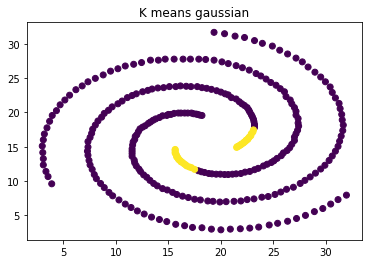

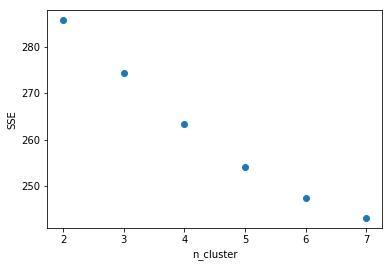

Sigma 2.0
n_clusters  2 silhouette score: -0.022970618776 -0.113665422611 rand_score: 0.0514015762509
n_clusters  3 silhouette score: -0.0606920902476 -0.206600374077 rand_score: 0.0577183273343
n_clusters  4 silhouette score: -0.110664009973 -0.352988998395 rand_score: 0.0792505294533
n_clusters  5 silhouette score: -0.127728273776 -0.343830043331 rand_score: 0.149712430465
n_clusters  6 silhouette score: -0.0731012401239 -0.323475971958 rand_score: 0.130488399948
n_clusters  7 silhouette score: -0.0598112881582 -0.262821597654 rand_score: 0.123734852301
Best n_clusters 2 2
adjusted_rand_score 0.0514015762509


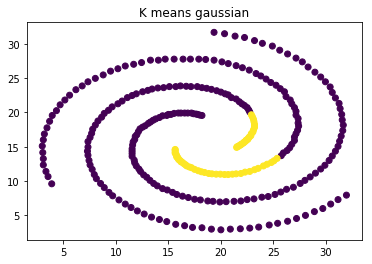

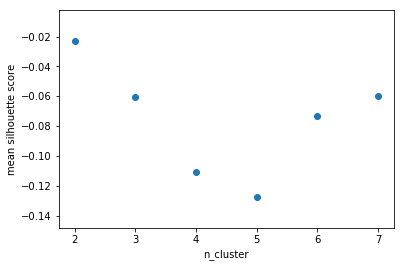

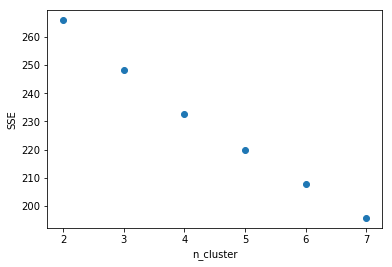

Sigma 3.0
n_clusters  2 silhouette score: 0.34721266437 0.369977332365 rand_score: -0.00255754787227
n_clusters  3 silhouette score: 0.329484852082 0.363732114359 rand_score: -0.00201796841521
n_clusters  4 silhouette score: 0.0839767879978 0.235558023787 rand_score: 0.0529760249594
n_clusters  5 silhouette score: 0.223275286376 0.347702608153 rand_score: 0.0568220881858
n_clusters  6 silhouette score: 0.287279819897 0.358981906402 rand_score: 0.0884394054541
n_clusters  7 silhouette score: 0.274419848834 0.31248918585 rand_score: 0.15575926607
Best n_clusters 2 2
adjusted_rand_score -0.00255754787227


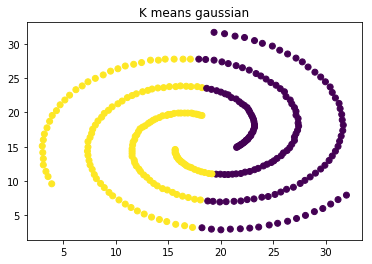

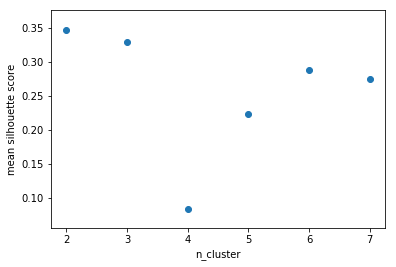

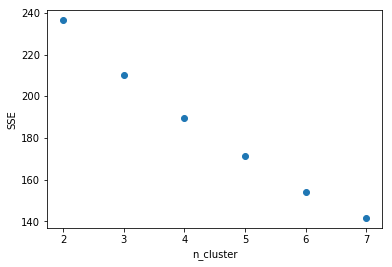

Sigma 5.0
n_clusters  2 silhouette score: 0.347561587011 0.368346913493 rand_score: -0.00288768948679
n_clusters  3 silhouette score: 0.36545970124 0.400707070595 rand_score: -0.00578280408227
n_clusters  4 silhouette score: 0.352597664279 0.378010486899 rand_score: -0.00412056522573


/home/chvlyl/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:74: RuntimeWarning: Mean of empty slice.


n_clusters  5 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  6 silhouette score: 0.347235616623 0.387085219313 rand_score: 0.0102994554918
n_clusters  7 silhouette score: -1 -1.0 rand_score: 0.0
Best n_clusters 3 3
adjusted_rand_score -0.00578280408227


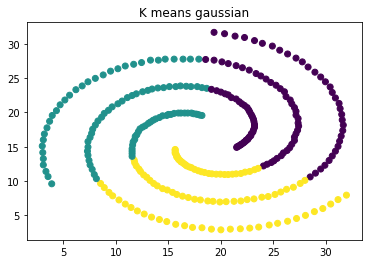

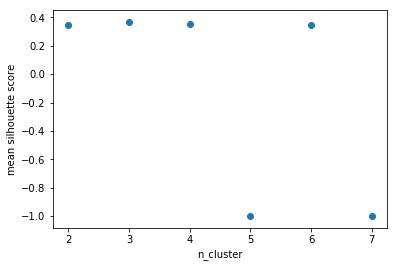

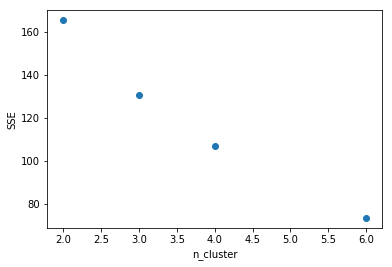

In [28]:
dn = 'spiral'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
for sigma in [1.0,2.0,3.0,5.0]:
    print("==================================")
    print("Sigma",sigma)
    result = run_k_means(data,labels,n_cluster_range,kernel='gaussian',sigma=sigma)

### --- Real data --

### letter

In [ ]:
dn = 'letter'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
### too slow, only test smaller range
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-3),true_n_clusters+3)
for sigma in [1.0,2.0,3.0,5.0]:
    print("==================================")
    print("Sigma",sigma)
    result = run_k_means(data,labels,n_cluster_range,n_init = 1,sigma = sigma,kernel='gaussian',
                         use_kmean_controid=True)

### wine

Sigma 1.0
n_clusters  2 silhouette score: 0.298722181597 0.336976292233 rand_score: 0.370227093228
n_clusters  3 silhouette score: 0.301349628999 0.331080558816 rand_score: 0.899156872946
n_clusters  4 silhouette score: 0.263388913649 0.297855985179 rand_score: 0.737603596487


/home/chvlyl/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:74: RuntimeWarning: Mean of empty slice.


n_clusters  5 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  6 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  7 silhouette score: -1 -1.0 rand_score: 0.0
Best n_clusters 3 2
adjusted_rand_score 0.899156872946


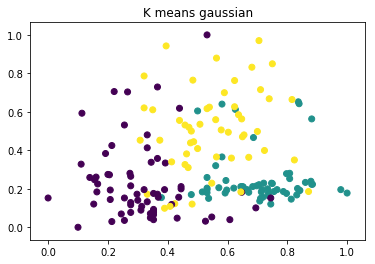

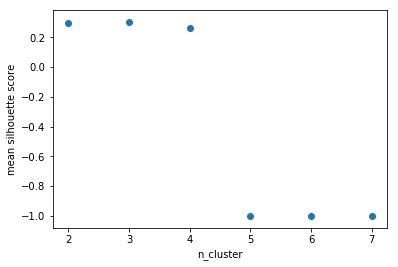

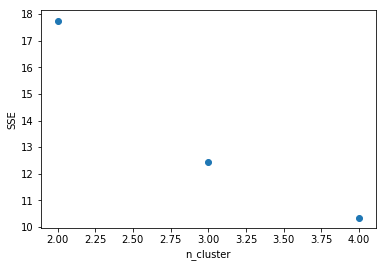

Sigma 2.0
n_clusters  2 silhouette score: 0.298722181597 0.336976292233 rand_score: 0.370227093228
n_clusters  3 silhouette score: 0.299366740649 0.329577885199 rand_score: 0.836844873315
n_clusters  4 silhouette score: 0.26146715048 0.296277643973 rand_score: 0.747431218846
n_clusters  5 silhouette score: 0.263786028452 0.274518914535 rand_score: 0.723350889257
n_clusters  6 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  7 silhouette score: -1 -1.0 rand_score: 0.0
Best n_clusters 3 2
adjusted_rand_score 0.836844873315


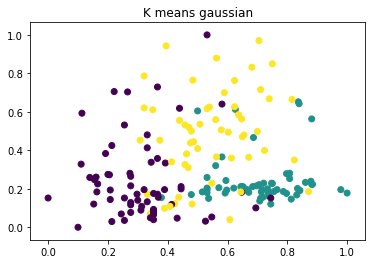

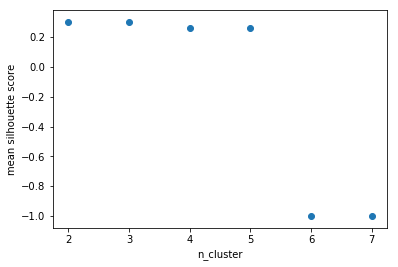

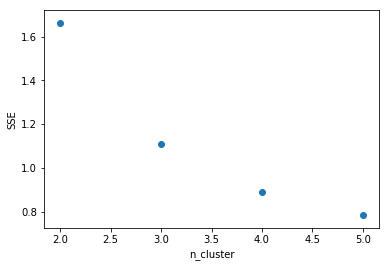

Sigma 3.0
n_clusters  2 silhouette score: 0.298722181597 0.336976292233 rand_score: 0.370227093228
n_clusters  3 silhouette score: 0.299366740649 0.329577885199 rand_score: 0.836844873315
n_clusters  4 silhouette score: 0.26146715048 0.296277643973 rand_score: 0.747431218846
n_clusters  5 silhouette score: 0.260334217259 0.278996999327 rand_score: 0.733028633893
n_clusters  6 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  7 silhouette score: -1 -1.0 rand_score: 0.0
Best n_clusters 3 2
adjusted_rand_score 0.836844873315


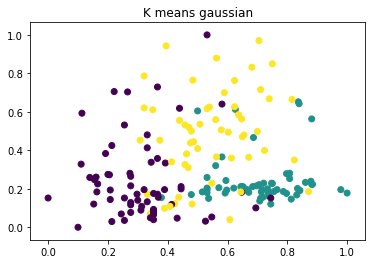

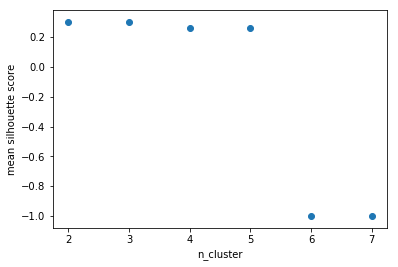

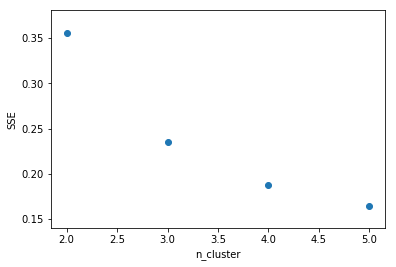

Sigma 5.0
n_clusters  2 silhouette score: 0.298722181597 0.336976292233 rand_score: 0.370227093228
n_clusters  3 silhouette score: 0.299366740649 0.329577885199 rand_score: 0.836844873315
n_clusters  4 silhouette score: 0.26146715048 0.296277643973 rand_score: 0.747431218846
n_clusters  5 silhouette score: 0.260334217259 0.278996999327 rand_score: 0.733028633893
n_clusters  6 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  7 silhouette score: -1 -1.0 rand_score: 0.0
Best n_clusters 3 2
adjusted_rand_score 0.836844873315


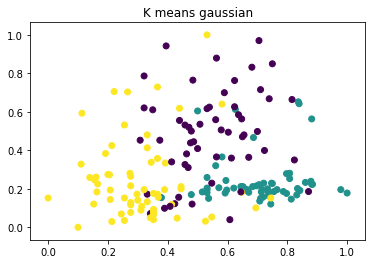

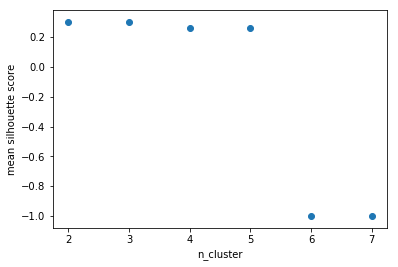

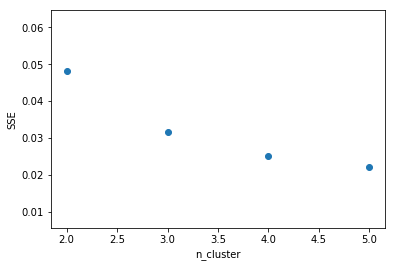

In [29]:
dn = 'wine'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
for sigma in [1.0,2.0,3.0,5.0]:
    print("==================================")
    print("Sigma",sigma)
    result = run_k_means(data,labels,n_cluster_range,kernel='gaussian',sigma=sigma)

### glass

Sigma 1.0
n_clusters  2 silhouette score: 0.375903214363 0.666124810364 rand_score: 0.129358310427
n_clusters  3 silhouette score: 0.296122466176 0.382721801372 rand_score: 0.218222898702
n_clusters  4 silhouette score: 0.325842177018 0.485919905966 rand_score: 0.254536075766
n_clusters  5 silhouette score: 0.209029439873 0.24285032818 rand_score: 0.204939563022


/home/chvlyl/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:74: RuntimeWarning: Mean of empty slice.


n_clusters  6 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  7 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  8 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  9 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  10 silhouette score: -1 -1.0 rand_score: 0.0
Best n_clusters 2 2
adjusted_rand_score 0.129358310427


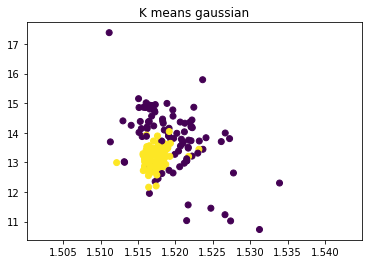

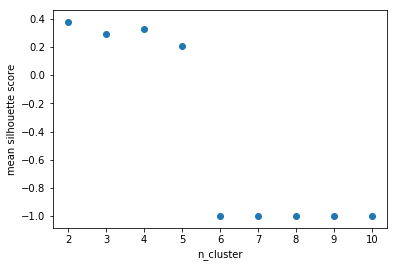

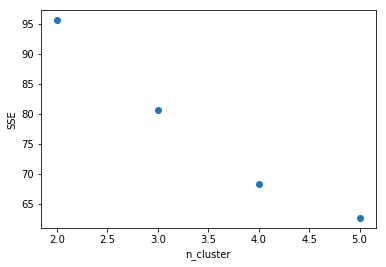

Sigma 2.0
n_clusters  2 silhouette score: 0.53939322727 0.714333649885 rand_score: 0.241864427728
n_clusters  3 silhouette score: 0.53974496072 0.697930888172 rand_score: 0.26323913311
n_clusters  4 silhouette score: 0.393452728396 0.523262140964 rand_score: 0.273811187098
n_clusters  5 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  6 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  7 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  8 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  9 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  10 silhouette score: -1 -1.0 rand_score: 0.0
Best n_clusters 3 2
adjusted_rand_score 0.26323913311


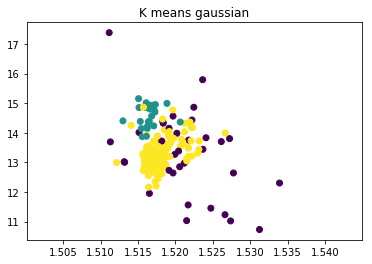

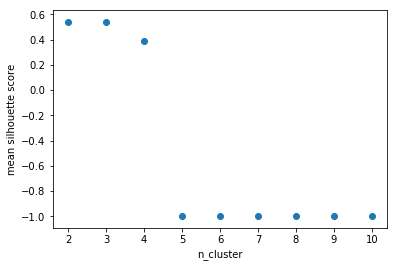

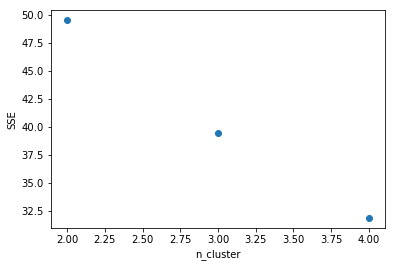

Sigma 3.0
n_clusters  2 silhouette score: 0.549931872061 0.708805762228 rand_score: 0.227059525982
n_clusters  3 silhouette score: 0.563530357526 0.670249145715 rand_score: 0.256835416096
n_clusters  4 silhouette score: 0.542478101498 0.669049998456 rand_score: 0.269485269095
n_clusters  5 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  6 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  7 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  8 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  9 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  10 silhouette score: -1 -1.0 rand_score: 0.0
Best n_clusters 3 2
adjusted_rand_score 0.256835416096


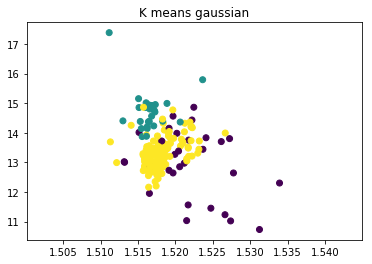

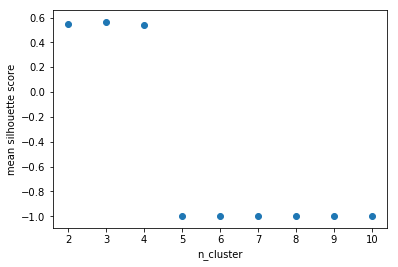

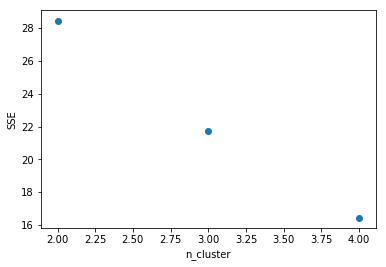

Sigma 5.0
n_clusters  2 silhouette score: 0.558160264996 0.702553915806 rand_score: 0.209235576057
n_clusters  3 silhouette score: 0.585605453863 0.682407508521 rand_score: 0.23370764892
n_clusters  4 silhouette score: 0.589036750418 0.671538929011 rand_score: 0.25347613132
n_clusters  5 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  6 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  7 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  8 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  9 silhouette score: -1 -1.0 rand_score: 0.0
n_clusters  10 silhouette score: -1 -1.0 rand_score: 0.0
Best n_clusters 4 2
adjusted_rand_score 0.25347613132


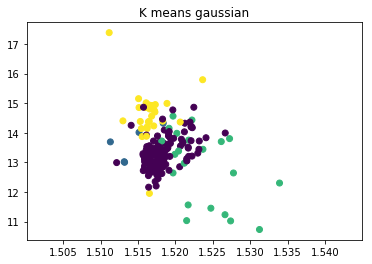

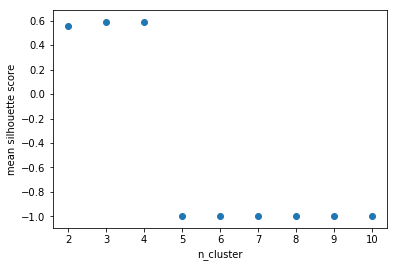

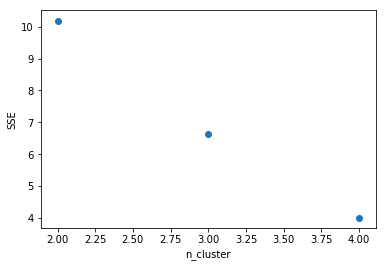

In [30]:
dn = 'glass'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
for sigma in [1.0,2.0,3.0,5.0]:
    print("==================================")
    print("Sigma",sigma)
    result = run_k_means(data,labels,n_cluster_range,kernel='gaussian',sigma=sigma)

### thyroid

In [ ]:
dn = 'thyroid'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
for sigma in [1.0,2.0,3.0,5.0]:
    print("==================================")
    print("Sigma",sigma)
    result = run_k_means(data,labels,n_cluster_range,kernel='gaussian',sigma=sigma)

### yeast

In [ ]:
dn = 'yeast'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
for sigma in [1.0,2.0,3.0,5.0]:
    print("==================================")
    print("Sigma",sigma)
    result = run_k_means(data,labels,n_cluster_range,kernel='gaussian',sigma=sigma)

### iris

In [ ]:
dn = 'iris'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
for sigma in [1.0,2.0,3.0,5.0]:
    print("==================================")
    print("Sigma",sigma)
    result = run_k_means(data,labels,n_cluster_range,kernel='gaussian',sigma=sigma)

### leaves

In [ ]:
dn = 'leaves'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-3),true_n_clusters+3)
for sigma in [1.0,2.0,3.0,5.0]:
    print("==================================")
    print("Sigma",sigma)
    result = run_k_means(data,labels,n_cluster_range,n_init = 1,sigma = sigma,kernel='gaussian',
                         use_kmean_controid=True)

### wdbc

In [ ]:
dn = 'wdbc'
(data,labels)  = cluster_data[dn]
true_n_clusters = len(np.unique(labels))
n_cluster_range = np.arange(np.maximum(2,true_n_clusters-5),true_n_clusters+5)
for sigma in [1.0,2.0,3.0,5.0]:
    print("==================================")
    print("Sigma",sigma)
    result = run_k_means(data,labels,n_cluster_range,n_init = 1,sigma = sigma,kernel='gaussian',
                         use_kmean_controid=True)

## Adaptive clustering

### Wrapper function

In [100]:
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon



def run_adaptive_clustering(data,labels,n0=None,lb_range=[0.1,0.5,1.0,2.0,5.0],
                        assign_outliers = 'nearest_cluster',
                           plot_cluster_result=True,
                           plot_silhouette=True):
    silhouette_mean_array   = []
    silhouette_median_array = []
    #sse_array = []
    sample_silhouette_history = {}
    for lb in lb_range:
        print("==================================")
        print("lambda",lb)
        result = adaptive_cluster(data, gap_par = lb, n0=n0,assign_outliers=assign_outliers, debug=False)
        y_pred = result['cluster_label']
        S = result['S']
        if len(np.unique(y_pred))>1:
            silhouette_avg = silhouette_score(data, y_pred)
            sample_silhouette_values = silhouette_samples(data, y_pred)
        else:
            silhouette_avg = -1
            sample_silhouette_values = [-1] * len(y_pred)
        sample_silhouette_history[lb] = sample_silhouette_values
        silhouette_median = np.median(sample_silhouette_values)
        rand_score = adjusted_rand_score(y_pred, labels)
        print("lambda ", lb, 'S',S,
              "silhouette score:", silhouette_avg,silhouette_median,
             "rand_score:",rand_score)
        silhouette_mean_array.append(silhouette_avg)
        silhouette_median_array.append(silhouette_median)
        #sse_array.append(result['best_sse'][0])
        if plot_cluster_result:
            plt.scatter(data[:, 0], data[:, 1], c=y_pred)
            plt.title("Adaptive clustering")
            plt.show()
        
    print('Best lambda',
          lb_range[np.argmax(silhouette_mean_array)],
          lb_range[np.argmax(silhouette_median_array)] )
    
        
    best_lambda = lb_range[np.argmax(silhouette_mean_array)]
    result = adaptive_cluster(data, gap_par = best_lambda, n0=n0,assign_outliers=assign_outliers,debug=False)
    y_pred = result['cluster_label']
    
    rand_score = adjusted_rand_score(y_pred, labels)
    result['adjusted_rand_score'] = rand_score
    print("adjusted_rand_score",rand_score)
    
    
        
        
    if plot_silhouette:
        plt.scatter(lb_range,silhouette_mean_array)
        plt.xlabel('lambda')
        plt.ylabel('mean silhouette score')
        plt.show()
    
        
    return(result)

### --- Simulated data ---

### Aggregation

lambda 0.1
lambda  0.1 S 160392 silhouette score: 0.421086844533 0.469304171435 rand_score: 0.879508344076


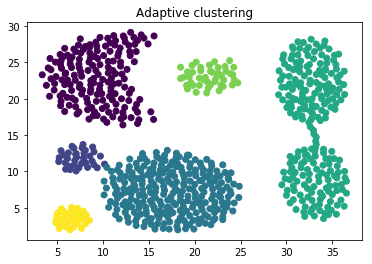

lambda 0.5
lambda  0.5 S 160392 silhouette score: 0.421086844533 0.469304171435 rand_score: 0.879508344076


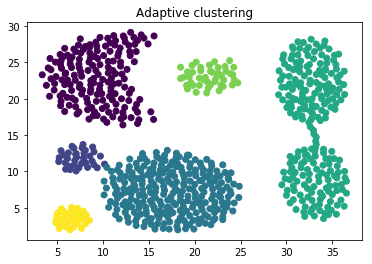

lambda 1.0
lambda  1.0 S 179432 silhouette score: 0.412005178218 0.460701050307 rand_score: 0.808943417036


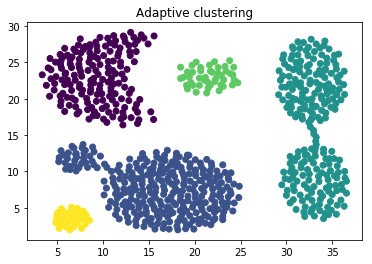

lambda 2.0
lambda  2.0 S 179432 silhouette score: 0.412005178218 0.460701050307 rand_score: 0.808943417036


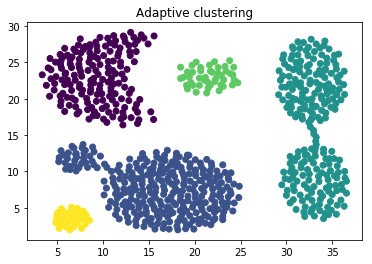

lambda 5.0
lambda  5.0 S 179432 silhouette score: 0.412005178218 0.460701050307 rand_score: 0.808943417036


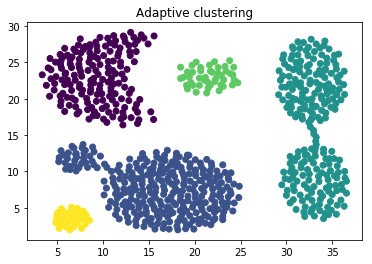

Best lambda 0.1 0.1
adjusted_rand_score 0.879508344076


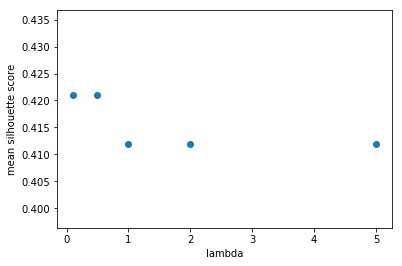

In [108]:
dn = 'Aggregation'
(data,labels)  = cluster_data[dn]
result = run_adaptive_clustering(data,labels,lb_range=[0.1,0.5,1.0,2.0,5.0])

### Compound

lambda 0.1
lambda  0.1 S 47191 silhouette score: 0.185434480164 0.290194843947 rand_score: 0.857633895798


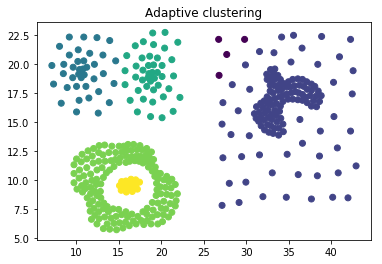

lambda 0.5
lambda  0.5 S 51163 silhouette score: 0.143327748442 0.227522446969 rand_score: 0.810178187291


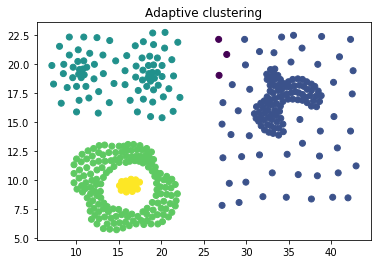

lambda 1.0
lambda  1.0 S 48013 silhouette score: 0.28010511726 0.536013814606 rand_score: 0.850612062419


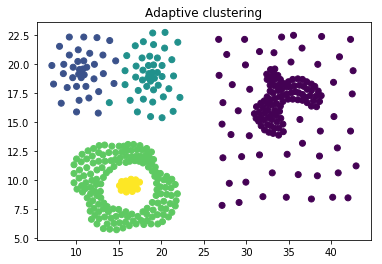

lambda 2.0
lambda  2.0 S 38289 silhouette score: 0.274274090227 0.452783917204 rand_score: 0.683464273067


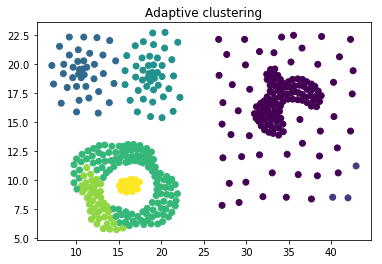

lambda 5.0
lambda  5.0 S 63061 silhouette score: 0.0340638165184 -0.105952941268 rand_score: 0.532410710468


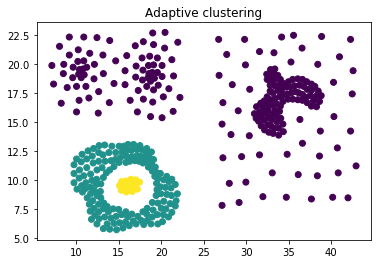

Best lambda 1.0 1.0
adjusted_rand_score 0.850612062419


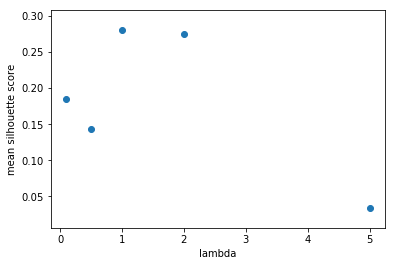

In [105]:
dn = 'Compound'
(data,labels)  = cluster_data[dn]
result = run_adaptive_clustering(data,labels,lb_range=[0.1,0.5,1.0,2.0,5.0])

lambda 0.1
lambda  0.1 S 47191 silhouette score: 0.176518452536 0.259372574913 rand_score: 0.860063252832


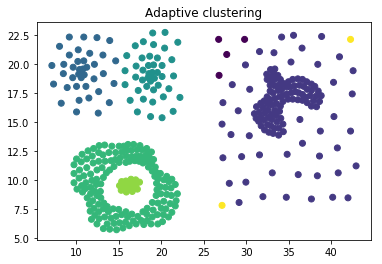

lambda 0.5
lambda  0.5 S 51163 silhouette score: 0.102806966484 0.129336606642 rand_score: 0.8111872523


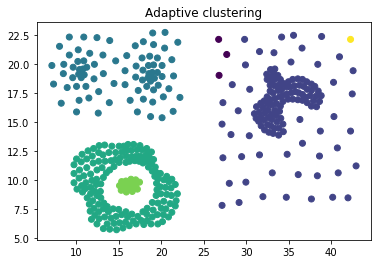

lambda 1.0
lambda  1.0 S 48013 silhouette score: 0.222194581245 0.363748075012 rand_score: 0.853880636352


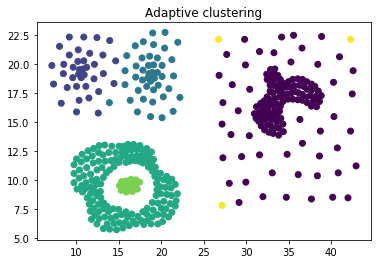

lambda 2.0
lambda  2.0 S 38289 silhouette score: 0.226240755228 0.386835703036 rand_score: 0.684283041596


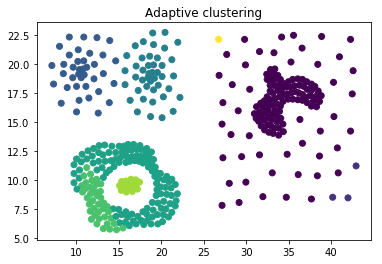

lambda 5.0
lambda  5.0 S 63061 silhouette score: 0.0340638165184 -0.105952941268 rand_score: 0.532410710468


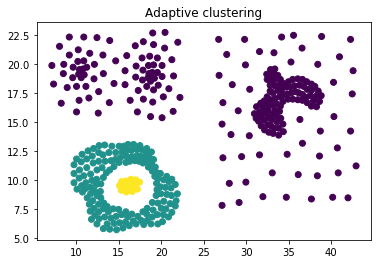

Best lambda 2.0 2.0
adjusted_rand_score 0.684283041596


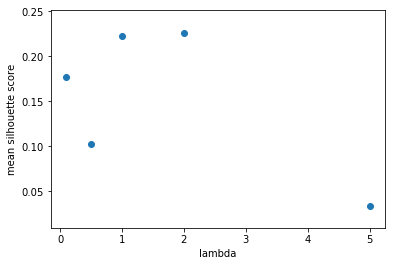

In [107]:
dn = 'Compound'
(data,labels)  = cluster_data[dn]
result = run_adaptive_clustering(data,labels,lb_range=[0.1,0.5,1.0,2.0,5.0],
                        assign_outliers = 'new_cluster')

### D31

In [ ]:
dn = 'D31'
(data,labels)  = cluster_data[dn]
result = run_adaptive_clustering(data,labels,lb_range=[0.005,0.01,0.05,0.1])

### flame

Sigma 1.0
n_clusters  2 silhouette score: 0.321753664743 0.379903713229
n_clusters  3 silhouette score: 0.301371996114 0.466067734761
n_clusters  4 silhouette score: 0.34310391146 0.434524165233
n_clusters  5 silhouette score: 0.316903839342 0.446473637552
n_clusters  6 silhouette score: 0.337863847094 0.401943328637
Best n_clusters 4 3
adjusted_rand_score 0.229049672276


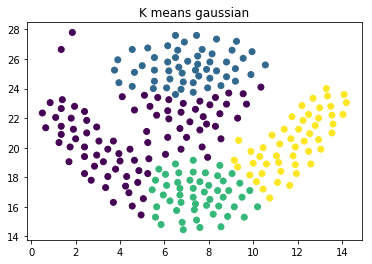

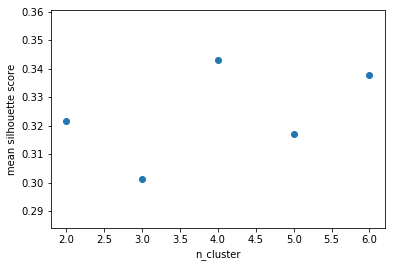

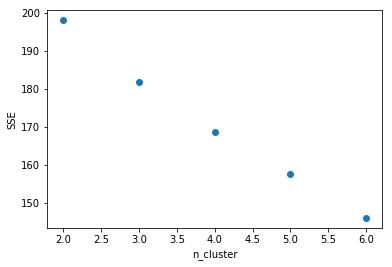

Sigma 2.0
n_clusters  2 silhouette score: 0.323822578143 0.382484898162
n_clusters  3 silhouette score: 0.406510630589 0.463298627401
n_clusters  4 silhouette score: 0.442618663395 0.495617201484
n_clusters  5 silhouette score: 0.402630074493 0.4511798327
n_clusters  6 silhouette score: 0.38085862263 0.413784379136
Best n_clusters 4 4
adjusted_rand_score 0.463567505224


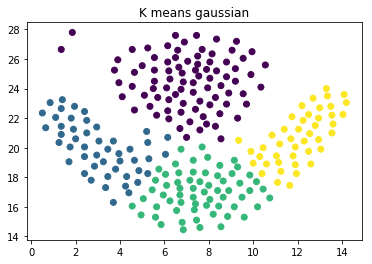

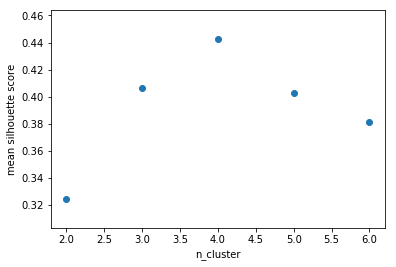

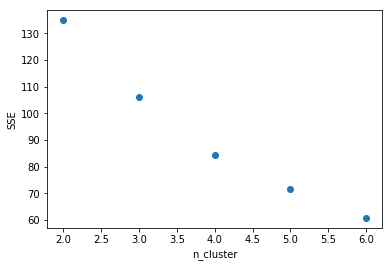

Sigma 3.0
n_clusters  2 silhouette score: 0.378717443856 0.416506310092
n_clusters  3 silhouette score: 0.416710102659 0.464883570103
n_clusters  4 silhouette score: 0.443951876069 0.496251023305
n_clusters  5 silhouette score: 0.403543961353 0.455854258188


/home/chvlyl/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice.


n_clusters  6 silhouette score: -1 -1.0
Best n_clusters 4 4
adjusted_rand_score 0.455961068856


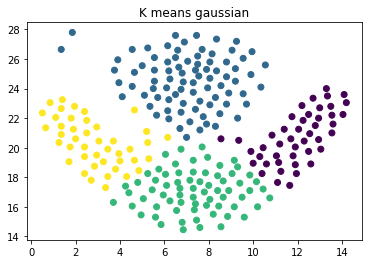

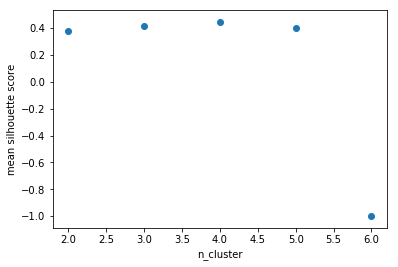

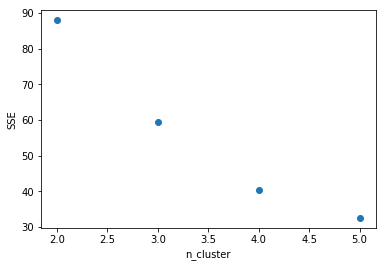

Sigma 5.0
n_clusters  2 silhouette score: 0.378687283053 0.41671580633
n_clusters  3 silhouette score: 0.410531931394 0.451742526389
n_clusters  4 silhouette score: -1 -1.0
n_clusters  5 silhouette score: -1 -1.0
n_clusters  6 silhouette score: -1 -1.0
Best n_clusters 3 3
adjusted_rand_score 0.549593450816


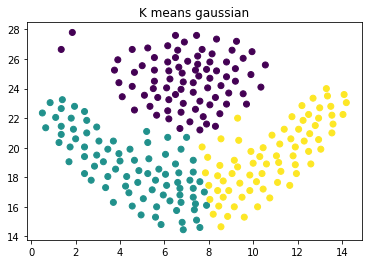

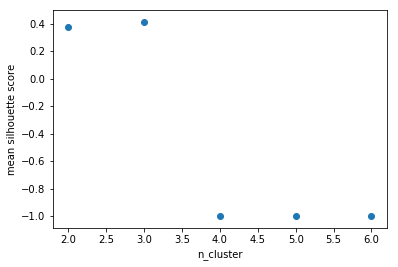

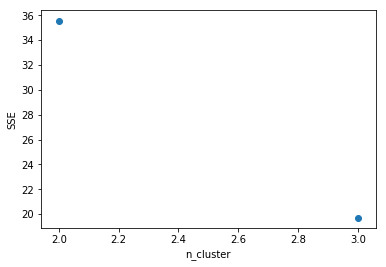

In [133]:
dn = 'flame'
(data,labels)  = cluster_data[dn]
result = run_adaptive_clustering(data,labels,lb_range=[0.01,0.5,1.0,2.0,5.0])

### jain

lambda 0.01
lambda  0.01 silhouette score: 0.254438805366 0.301570568555 rand_score: 0.221473615022


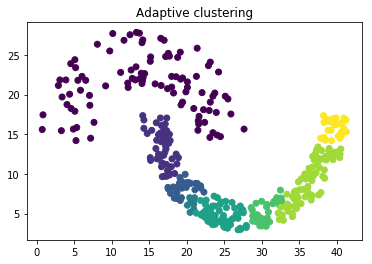

lambda 0.5
lambda  0.5 silhouette score: 0.191379591743 0.318404858248 rand_score: 0.493801854165


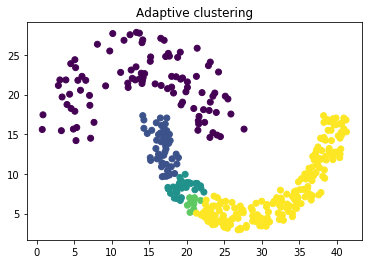

lambda 1.0
lambda  1.0 silhouette score: 0.297219561675 0.409758658242 rand_score: 0.672261394177


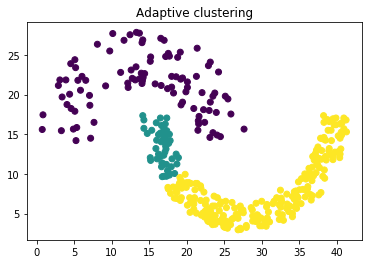

lambda 2.0
lambda  2.0 silhouette score: 0.402460044276 0.510309827879 rand_score: 1.0


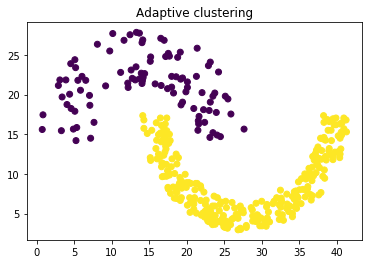

lambda 5.0


KeyboardInterrupt: 

In [297]:
dn = 'jain'
(data,labels)  = cluster_data[dn]
result = run_adaptive_clustering(data,labels,lb_range=[0.01,0.5,1.0,2.0,5.0])

### pathbased

lambda 0.01
lambda  0.01 silhouette score: 0.265020161872 0.578519815415 rand_score: 0.969870390481


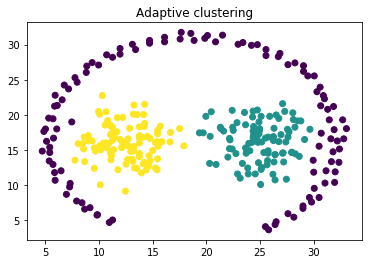

lambda 0.5
lambda  0.5 silhouette score: 0.23877722123 0.296337330363 rand_score: 0.523502866532


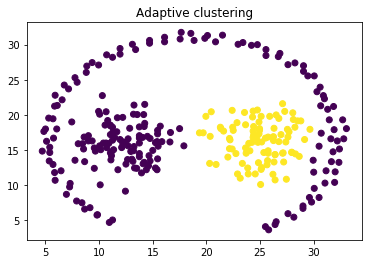

lambda 1.0
lambda  1.0 silhouette score: -1 -1.0 rand_score: 0.0


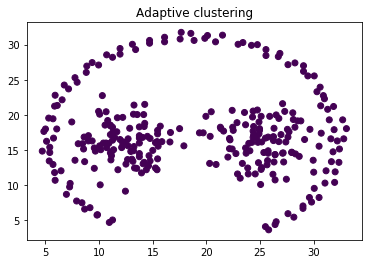

lambda 2.0
lambda  2.0 silhouette score: -1 -1.0 rand_score: 0.0


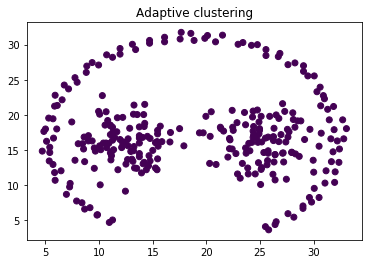

lambda 5.0
lambda  5.0 silhouette score: -1 -1.0 rand_score: 0.0


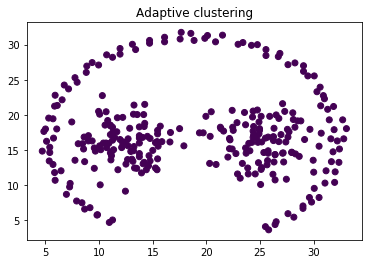

Best lambda 0.01 0.01
adjusted_rand_score 0.969870390481


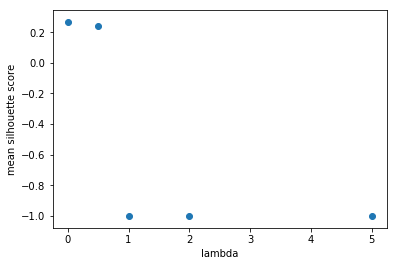

In [295]:
dn = 'pathbased'
(data,labels)  = cluster_data[dn]
result = run_adaptive_clustering(data,labels,lb_range=[0.01,0.5,1.0,2.0,5.0])

### R15

lambda 0.01
lambda  0.01 silhouette score: 0.715734261934 0.783085578461 rand_score: 0.927843860733


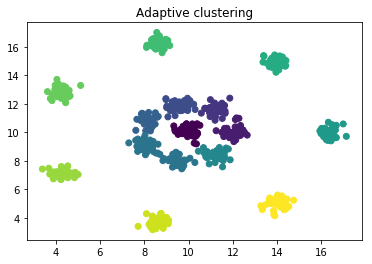

lambda 0.5
lambda  0.5 silhouette score: 0.62587995693 0.763135096375 rand_score: 0.766789955227


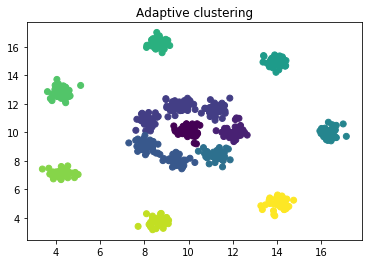

lambda 1.0
lambda  1.0 silhouette score: 0.547780208831 0.779405269438 rand_score: 0.645771732703


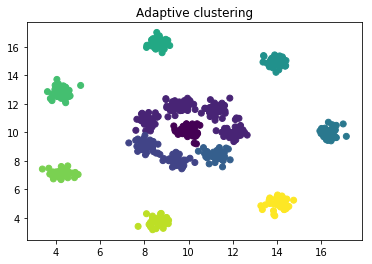

lambda 2.0
lambda  2.0 silhouette score: 0.469982139155 0.560372340969 rand_score: 0.420065351567


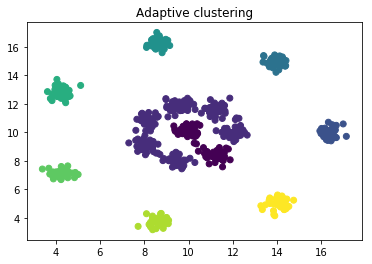

lambda 5.0
lambda  5.0 silhouette score: 0.469982139155 0.560372340969 rand_score: 0.420065351567


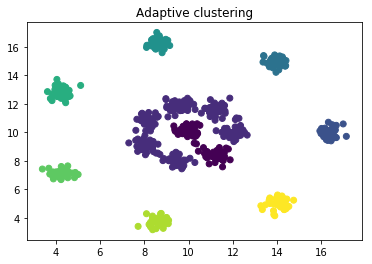

Best lambda 0.01 0.01
adjusted_rand_score 0.420065351567


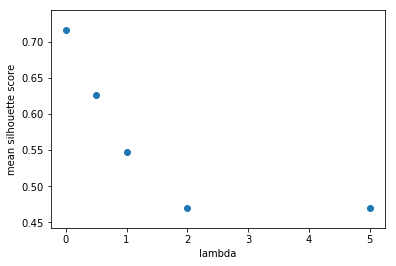

In [292]:
dn = 'R15'
(data,labels)  = cluster_data[dn]
result = run_adaptive_clustering(data,labels,lb_range=[0.01,0.5,1.0,2.0,5.0])

### spiral

lambda 0.01
lambda  0.01 S 3406 silhouette score: 0.311799980472 0.39462787553 rand_score: 0.124653310635


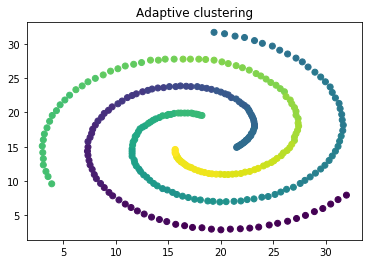

lambda 0.5
lambda  0.5 S 13214 silhouette score: -0.183921969845 -0.317411927204 rand_score: 0.666698691477


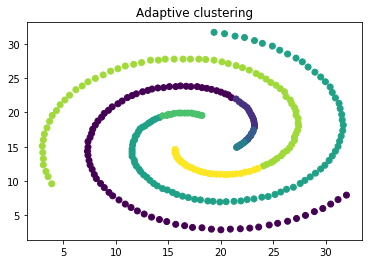

lambda 1.0
lambda  1.0 S 17716 silhouette score: -0.282989999084 -0.344987043309 rand_score: 0.822043007417


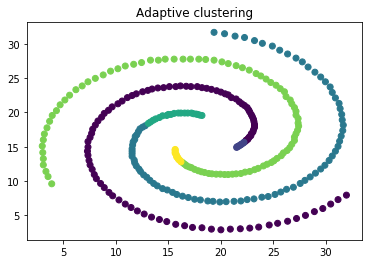

lambda 2.0
lambda  2.0 S 24818 silhouette score: 0.00134429734428 -0.0114935479358 rand_score: 1.0


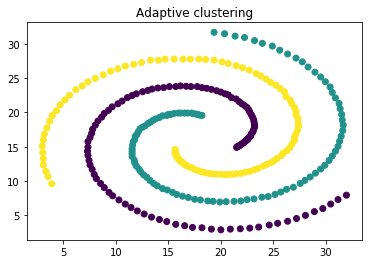

lambda 5.0
lambda  5.0 S 25140 silhouette score: 0.00134429734428 -0.0114935479358 rand_score: 1.0


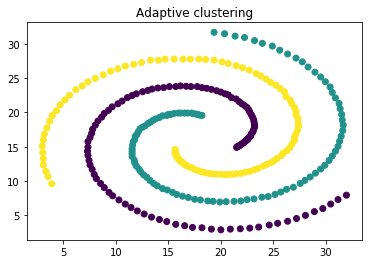

Best lambda 0.01 0.01
adjusted_rand_score 0.124653310635


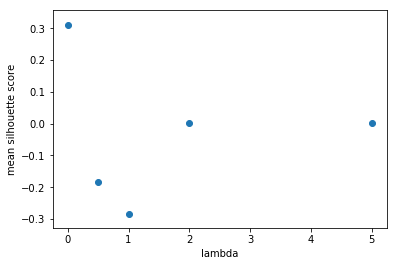

In [66]:
dn = 'spiral'
(data,labels)  = cluster_data[dn]
result = run_adaptive_clustering(data,labels,n0=3,lb_range=[0.01,0.5,1.0,2.0,5.0])
#result = run_adaptive_clustering(data,labels, n0=3,lb_range=[0.01])

### --- Real data --

The adaptive clustering does not work well on the real data. I think this is due to large p. So I use PCA to get the first three components of the data and then redo the adaptive clustering.

### letter

In [318]:
dn = 'letter'
(data,labels)  = cluster_data[dn]
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
pca.fit(data)
data_pca = pca.transform(data)
data_pca.shape
result = run_adaptive_clustering(data_pca,labels,lb_range=[0.01,0.5,1.0,2.0,5.0])

lambda 0.01


KeyboardInterrupt: 

### wine

lambda 0.1
lambda  0.1 S 24580 silhouette score: -1 -1.0 rand_score: 0.0


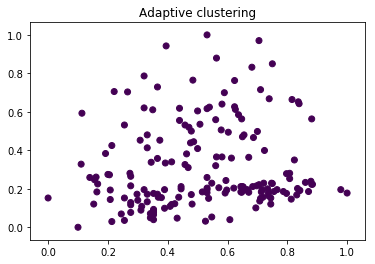

lambda 0.2
lambda  0.2 S 24699 silhouette score: -1 -1.0 rand_score: 0.0


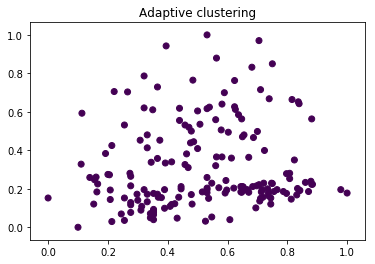

lambda 0.5
lambda  0.5 S 24729 silhouette score: -1 -1.0 rand_score: 0.0


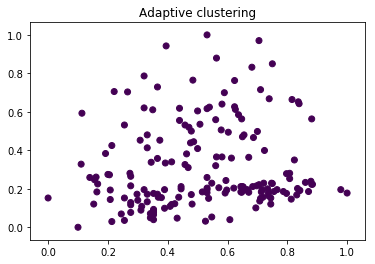

lambda 1.0
lambda  1.0 S 24749 silhouette score: -1 -1.0 rand_score: 0.0


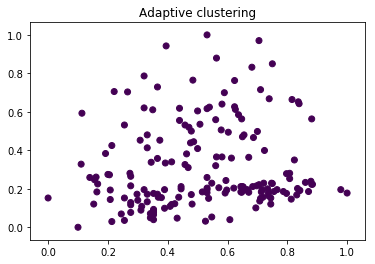

lambda 2.0
lambda  2.0 S 24757 silhouette score: -1 -1.0 rand_score: 0.0


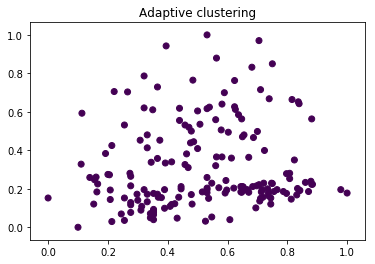

lambda 5.0
lambda  5.0 S 24773 silhouette score: -1 -1.0 rand_score: 0.0


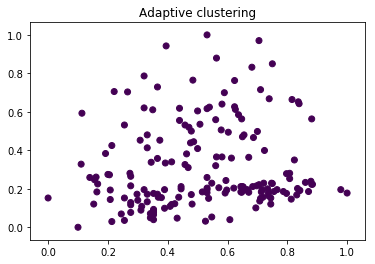

Best lambda 0.1 0.1
adjusted_rand_score 0.0


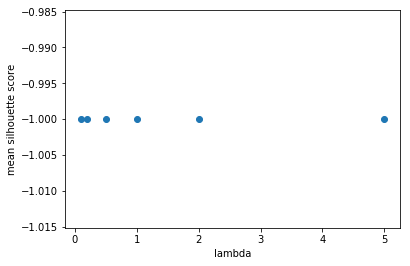

In [76]:
dn = 'wine'
(data,labels)  = cluster_data[dn]
result = run_adaptive_clustering(data,labels,n0=5,lb_range=[0.1,0.2,0.5,1.0,2.0,5.0])

In [77]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
pca.fit(data)
data_pca = pca.transform(data)
data_pca.shape

(178, 3)

lambda 0.01
lambda  0.01 S 2984 silhouette score: 0.0995246849397 0.116398510944 rand_score: 0.279937458825


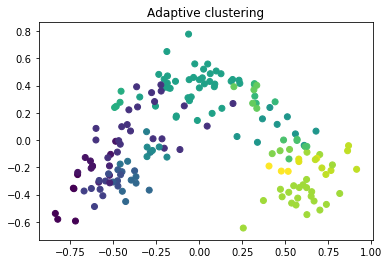

lambda 0.5
lambda  0.5 S 14160 silhouette score: 0.18196250354 0.299592307446 rand_score: 0.452204136706


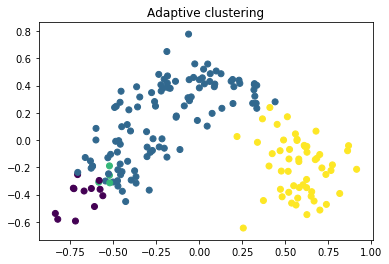

lambda 1.0
lambda  1.0 S 23650 silhouette score: 0.166050650048 0.335246667294 rand_score: 0.0223297240869


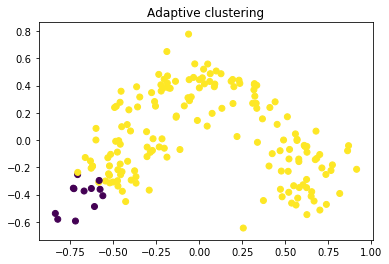

lambda 2.0
lambda  2.0 S 26070 silhouette score: -1 -1.0 rand_score: 0.0


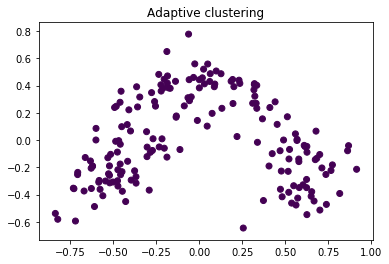

lambda 5.0
lambda  5.0 S 26070 silhouette score: -1 -1.0 rand_score: 0.0


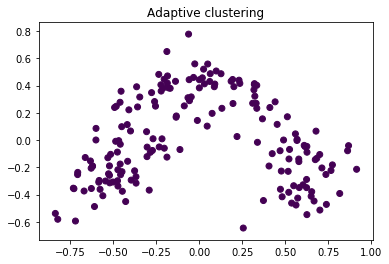

Best lambda 0.5 1.0
adjusted_rand_score 0.452204136706


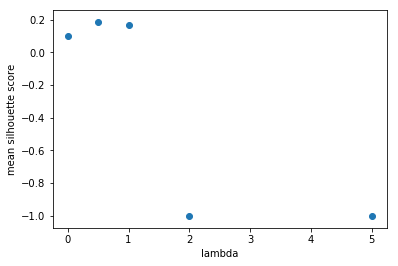

In [78]:
dn = 'wine'
result = run_adaptive_clustering(data_pca,labels,n0=3,lb_range=[0.01,0.5,1.0,2.0,5.0])

lambda -0.5
lambda  -0.5 S 2783 silhouette score: -0.137777451384 -0.140035130483 rand_score: 0.192005582936


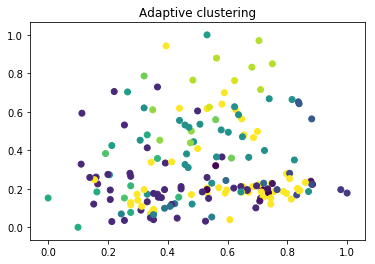

lambda -0.2
lambda  -0.2 S 6823 silhouette score: -0.108085260626 -0.106466553562 rand_score: 0.26696174447


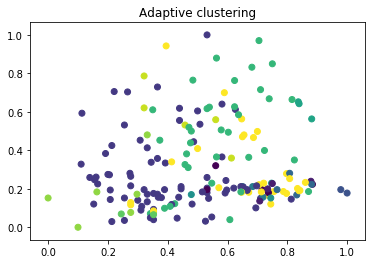

lambda -0.15
lambda  -0.15 S 11783 silhouette score: -0.190516109274 -0.244466995499 rand_score: 0.0862138639303


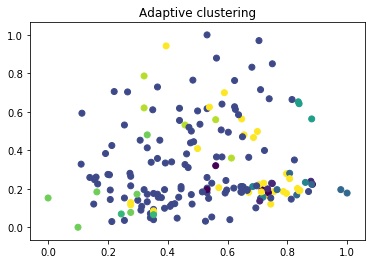

lambda -0.1
lambda  -0.1 S 10540 silhouette score: -0.0832023202075 -0.0537384780517 rand_score: 0.306834108672


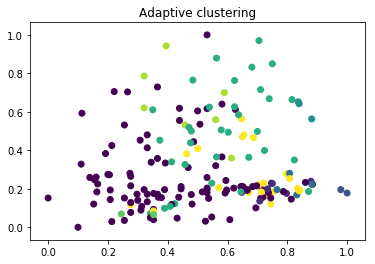

lambda 0
lambda  0 S 22351 silhouette score: -0.0846285957164 -0.0126502172617 rand_score: 0.00489760464304


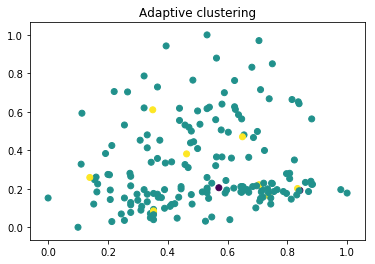

Best lambda -0.1 0
adjusted_rand_score 0.306834108672


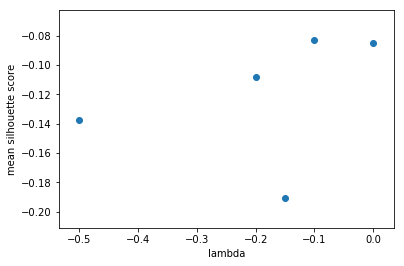

In [111]:
dn = 'wine'
(data,labels)  = cluster_data[dn]
result = run_adaptive_clustering(data,labels,n0=5,
                                 lb_range=[-0.5,-0.2,-0.15,-0.1,0],
                                assign_outliers = 'new_cluster')

### glass

lambda 0.01
h_k 4.6019724235
h_k 4.75335465255
h_k 4.90606340631
h_k 5.01952605465
h_k 5.17425765011
h_k 5.40418040645
h_k 5.66742744656
h_k 5.73418837616
h_k 5.9451982546
h_k 6.18666311099
lambda  0.01 silhouette score: -0.230957875634 -0.391316329556 rand_score: 0.0242860399422


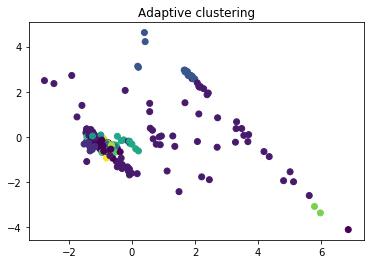

lambda 0.5
h_k 4.6019724235
h_k 4.75335465255
h_k 4.90606340631
h_k 5.01952605465
h_k 5.17425765011
h_k 5.40418040645
h_k 5.66742744656
h_k 5.73418837616
h_k 5.9451982546
h_k 6.18666311099
lambda  0.5 silhouette score: -0.389562057023 -0.500152364808 rand_score: -0.014391588566


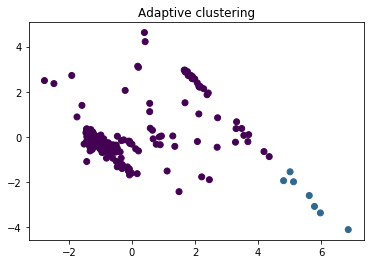

lambda 1.0
h_k 4.6019724235
h_k 4.75335465255
h_k 4.90606340631
h_k 5.01952605465
h_k 5.17425765011
h_k 5.40418040645
h_k 5.66742744656
h_k 5.73418837616
h_k 5.9451982546
h_k 6.18666311099
lambda  1.0 silhouette score: 0.622317178488 0.730581310614 rand_score: -0.0131763340762


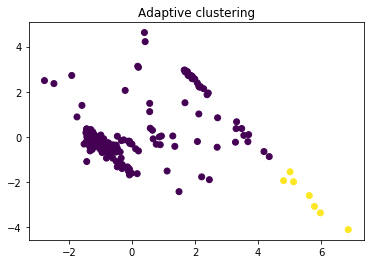

lambda 2.0
h_k 4.6019724235
h_k 4.75335465255
h_k 4.90606340631
h_k 5.01952605465
h_k 5.17425765011
h_k 5.40418040645
h_k 5.66742744656
h_k 5.73418837616
h_k 5.9451982546
h_k 6.18666311099
lambda  2.0 silhouette score: 0.622317178488 0.730581310614 rand_score: -0.0131763340762


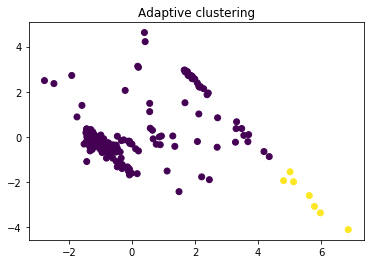

lambda 5.0
h_k 4.6019724235
h_k 4.75335465255
h_k 4.90606340631
h_k 5.01952605465
h_k 5.17425765011
h_k 5.40418040645
h_k 5.66742744656
h_k 5.73418837616
h_k 5.9451982546
h_k 6.18666311099
lambda  5.0 silhouette score: 0.628337448437 0.737895631243 rand_score: -0.01020452189


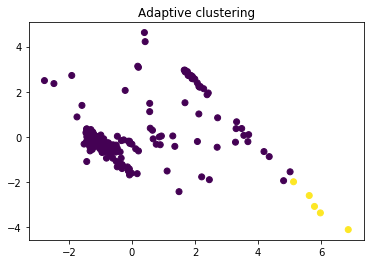

Best lambda 5.0 5.0
h_k 4.6019724235
h_k 4.75335465255
h_k 4.90606340631
h_k 5.01952605465
h_k 5.17425765011
h_k 5.40418040645
h_k 5.66742744656
h_k 5.73418837616
h_k 5.9451982546
h_k 6.18666311099
adjusted_rand_score -0.01020452189


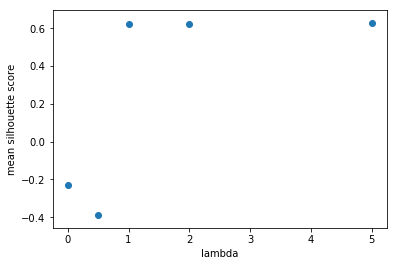

In [327]:
dn = 'glass'
(data,labels)  = cluster_data[dn]
#####
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
pca.fit(data)
data_pca = pca.transform(data)
data_pca.shape
####
result = run_adaptive_clustering(data_pca,labels,lb_range=[0.01,0.5,1.0,2.0,5.0])

lambda -0.5
lambda  -0.5 S 510 silhouette score: -0.300360815961 -0.527356960814 rand_score: 0.033385300824


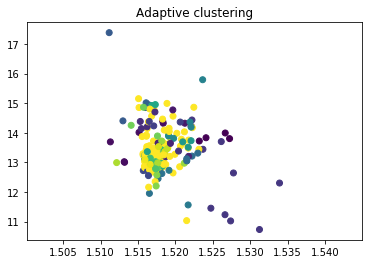

lambda -0.2
lambda  -0.2 S 594 silhouette score: -0.292254347458 -0.44682298645 rand_score: 0.0630660277342


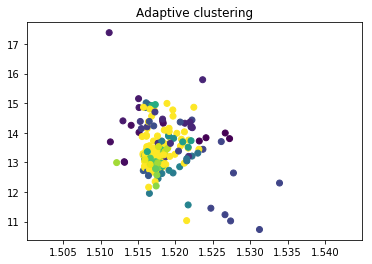

lambda -0.15
lambda  -0.15 S 594 silhouette score: -0.292254347458 -0.44682298645 rand_score: 0.0630660277342


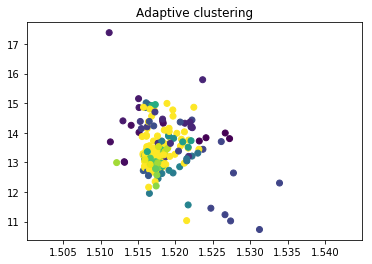

lambda -0.1
lambda  -0.1 S 634 silhouette score: -0.283473906031 -0.440004652249 rand_score: 0.075097984933


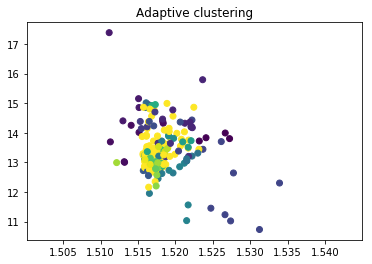

lambda 0
lambda  0 S 954 silhouette score: -0.308138088463 -0.480417047112 rand_score: 0.068645681951


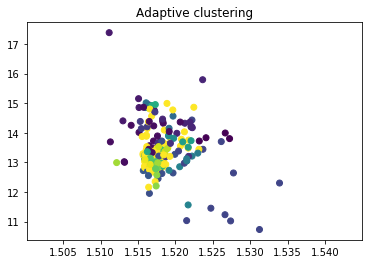

lambda 0.1
lambda  0.1 S 2640 silhouette score: -0.341580463527 -0.456850997591 rand_score: 0.0622060959833


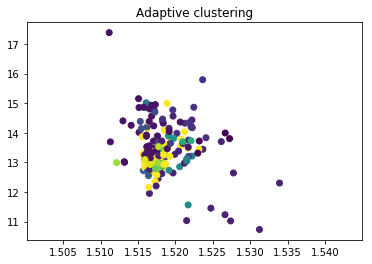

lambda 1.0
lambda  1.0 S 11729 silhouette score: -0.42429700527 -0.471079076948 rand_score: 0.0211932609944


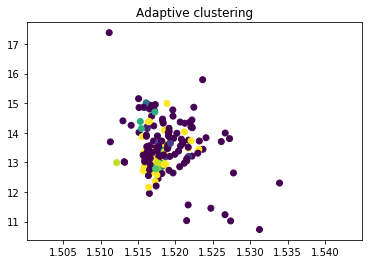

lambda 2
lambda  2 S 12151 silhouette score: -0.420670200029 -0.453608035471 rand_score: 0.0307925412353


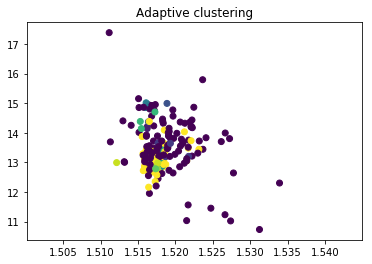

Best lambda -0.1 -0.1
adjusted_rand_score 0.075097984933


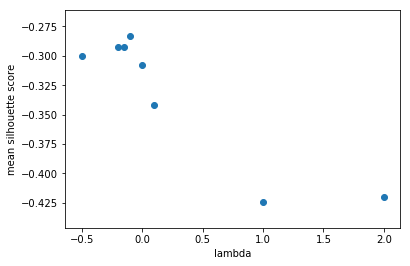

In [114]:
dn = 'glass'
(data,labels)  = cluster_data[dn]
result = run_adaptive_clustering(data,labels,n0=5,
                                 lb_range=[-0.5,-0.2,-0.15,-0.1,0,0.1,1.0,2],
                                assign_outliers = 'new_cluster')

### thyroid

lambda 0.01
h_k 0.49503452968
h_k 0.516310703141
h_k 0.534918805298
h_k 0.549287077669
h_k 0.570178408352
h_k 0.587508580464
h_k 0.605882094735
h_k 0.622620271683
h_k 0.638982251869
h_k 0.658953410824
h_k 0.682295412929
h_k 0.712917553073
h_k 0.739608780767
h_k 0.76232837786
h_k 0.791982754536
h_k 0.810014055259
h_k 0.831965641044
h_k 0.853639011463
h_k 0.875210995115
h_k 0.896221695579
h_k 0.914471774682
h_k 0.933069514149
h_k 0.951671667865
lambda  0.01 silhouette score: -0.122578914828 -0.133041553805 rand_score: 0.0898464141481


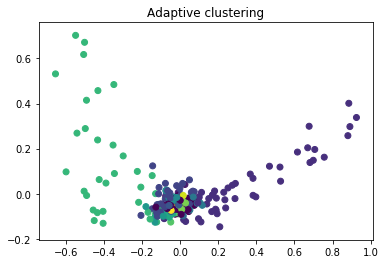

lambda 0.5
h_k 0.49503452968
h_k 0.516310703141
h_k 0.534918805298
h_k 0.549287077669
h_k 0.570178408352
h_k 0.587508580464
h_k 0.605882094735
h_k 0.622620271683
h_k 0.638982251869
h_k 0.658953410824
h_k 0.682295412929
h_k 0.712917553073
h_k 0.739608780767
h_k 0.76232837786
h_k 0.791982754536
h_k 0.810014055259
h_k 0.831965641044
h_k 0.853639011463
h_k 0.875210995115
h_k 0.896221695579
h_k 0.914471774682
h_k 0.933069514149
h_k 0.951671667865
lambda  0.5 silhouette score: -0.25163661241 -0.325906702199 rand_score: 0.236424381335


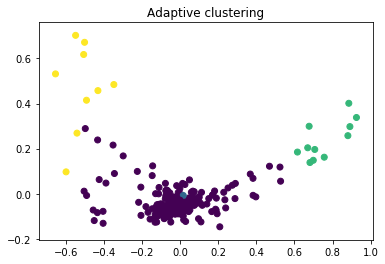

lambda 1.0
h_k 0.49503452968
h_k 0.516310703141
h_k 0.534918805298
h_k 0.549287077669
h_k 0.570178408352
h_k 0.587508580464
h_k 0.605882094735
h_k 0.622620271683
h_k 0.638982251869
h_k 0.658953410824
h_k 0.682295412929
h_k 0.712917553073
h_k 0.739608780767
h_k 0.76232837786
h_k 0.791982754536
h_k 0.810014055259
h_k 0.831965641044
h_k 0.853639011463
h_k 0.875210995115
h_k 0.896221695579
h_k 0.914471774682
h_k 0.933069514149
h_k 0.951671667865
lambda  1.0 silhouette score: 0.600465136069 0.693154025586 rand_score: 0.25197506773


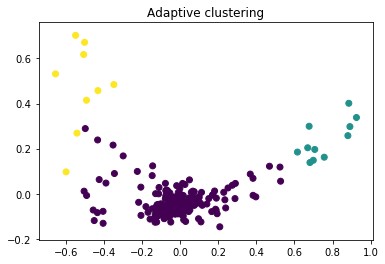

lambda 2.0
h_k 0.49503452968
h_k 0.516310703141
h_k 0.534918805298
h_k 0.549287077669
h_k 0.570178408352
h_k 0.587508580464
h_k 0.605882094735
h_k 0.622620271683
h_k 0.638982251869
h_k 0.658953410824
h_k 0.682295412929
h_k 0.712917553073
h_k 0.739608780767
h_k 0.76232837786
h_k 0.791982754536
h_k 0.810014055259
h_k 0.831965641044
h_k 0.853639011463
h_k 0.875210995115
h_k 0.896221695579
h_k 0.914471774682
h_k 0.933069514149
h_k 0.951671667865
lambda  2.0 silhouette score: 0.604226109424 0.700555332631 rand_score: 0.238973935054


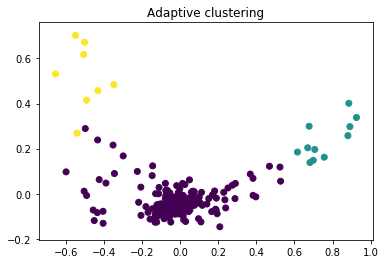

lambda 5.0
h_k 0.49503452968
h_k 0.516310703141
h_k 0.534918805298
h_k 0.549287077669
h_k 0.570178408352
h_k 0.587508580464
h_k 0.605882094735
h_k 0.622620271683
h_k 0.638982251869
h_k 0.658953410824
h_k 0.682295412929
h_k 0.712917553073
h_k 0.739608780767
h_k 0.76232837786
h_k 0.791982754536
h_k 0.810014055259
h_k 0.831965641044
h_k 0.853639011463
h_k 0.875210995115
h_k 0.896221695579
h_k 0.914471774682
h_k 0.933069514149
h_k 0.951671667865
lambda  5.0 silhouette score: 0.606561712898 0.707150109838 rand_score: 0.226072133756


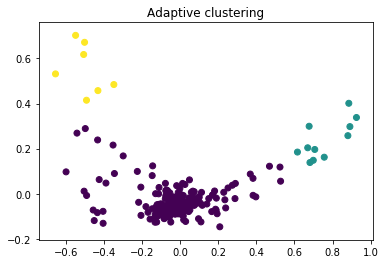

Best lambda 5.0 5.0
h_k 0.49503452968
h_k 0.516310703141
h_k 0.534918805298
h_k 0.549287077669
h_k 0.570178408352
h_k 0.587508580464
h_k 0.605882094735
h_k 0.622620271683
h_k 0.638982251869
h_k 0.658953410824
h_k 0.682295412929
h_k 0.712917553073
h_k 0.739608780767
h_k 0.76232837786
h_k 0.791982754536
h_k 0.810014055259
h_k 0.831965641044
h_k 0.853639011463
h_k 0.875210995115
h_k 0.896221695579
h_k 0.914471774682
h_k 0.933069514149
h_k 0.951671667865
adjusted_rand_score 0.226072133756


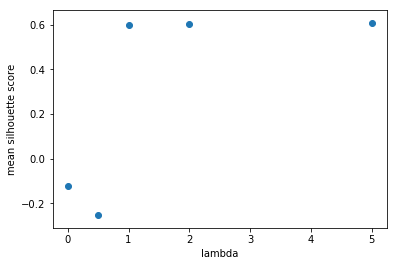

In [324]:
dn = 'thyroid'
(data,labels)  = cluster_data[dn]
#####
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
pca.fit(data)
data_pca = pca.transform(data)
data_pca.shape
####
result = run_adaptive_clustering(data_pca,labels,lb_range=[0.01,0.5,1.0,2.0,5.0])

lambda -0.5
lambda  -0.5 S 535 silhouette score: -0.221711776979 -0.465436689979 rand_score: 0.289726903657


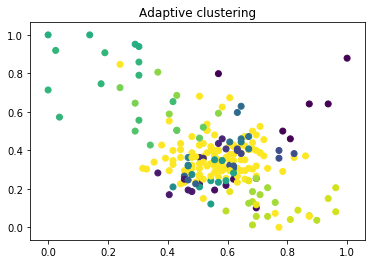

lambda -0.2
lambda  -0.2 S 607 silhouette score: -0.20394019274 -0.443873646731 rand_score: 0.287755049911


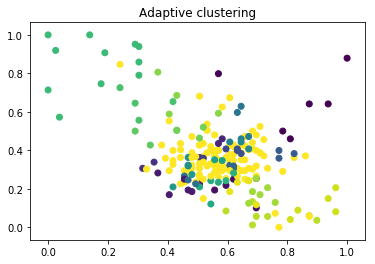

lambda -0.15
lambda  -0.15 S 613 silhouette score: -0.197166042395 -0.432649628626 rand_score: 0.287972881255


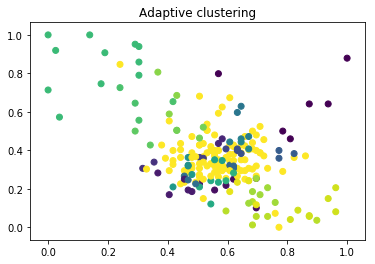

lambda -0.1
lambda  -0.1 S 727 silhouette score: -0.189746652248 -0.432509176279 rand_score: 0.309577342387


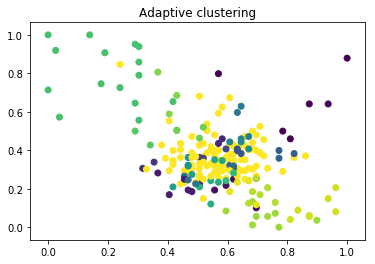

lambda 0
lambda  0 S 1185 silhouette score: -0.19838906925 -0.363291696821 rand_score: 0.290436139305


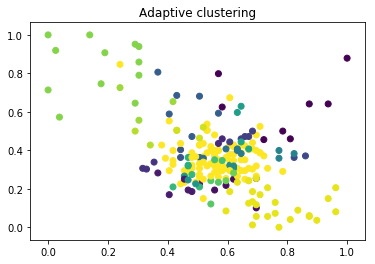

Best lambda -0.1 0
adjusted_rand_score 0.309577342387


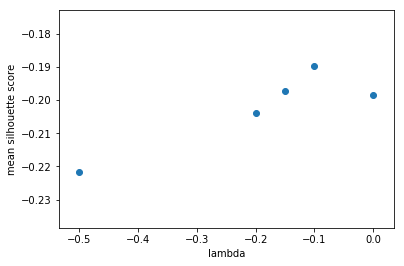

In [113]:
dn = 'thyroid'
(data,labels)  = cluster_data[dn]
result = run_adaptive_clustering(data,labels,n0=5,
                                 lb_range=[-0.5,-0.2,-0.15,-0.1,0],
                                assign_outliers = 'new_cluster')

### yeast

In [329]:
dn = 'yeast'
(data,labels)  = cluster_data[dn]
#####
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
pca.fit(data)
data_pca = pca.transform(data)
data_pca.shape
####
result = run_adaptive_clustering(data_pca,labels,lb_range=[0.01,0.5,1.0,2.0,5.0])

lambda 0.01
h_k 0.485565041998


KeyboardInterrupt: 

### iris

lambda 0.01
h_k 0.370384206011
h_k 0.384220871577
h_k 0.391298573263
h_k 0.401707546026
h_k 0.411089916649
h_k 0.422264349076
h_k 0.439819576956
h_k 0.470506686176
h_k 0.518081273987
h_k 0.54355095521
h_k 0.576939385997
h_k 0.623806866916
h_k 0.690344751627
h_k 0.762065674338
h_k 0.837375321759
h_k 0.876241529892
lambda  0.01 silhouette score: 0.356581588109 0.456355278873 rand_score: 0.492024962025


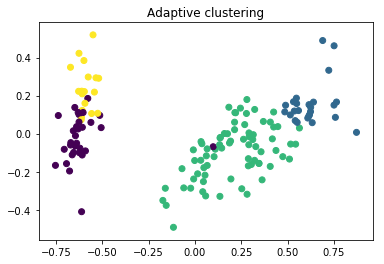

lambda 0.5
h_k 0.370384206011
h_k 0.384220871577
h_k 0.391298573263
h_k 0.401707546026
h_k 0.411089916649
h_k 0.422264349076
h_k 0.439819576956
h_k 0.470506686176
h_k 0.518081273987
h_k 0.54355095521
h_k 0.576939385997
h_k 0.623806866916
h_k 0.690344751627
h_k 0.762065674338
h_k 0.837375321759
h_k 0.876241529892
lambda  0.5 silhouette score: 0.635263270368 0.659113077493 rand_score: 0.568115942029


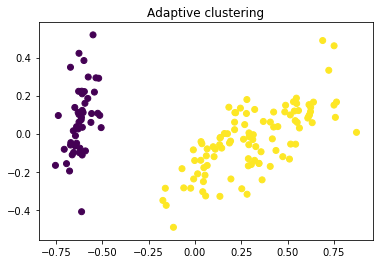

lambda 1.0
h_k 0.370384206011
h_k 0.384220871577
h_k 0.391298573263
h_k 0.401707546026
h_k 0.411089916649
h_k 0.422264349076
h_k 0.439819576956
h_k 0.470506686176
h_k 0.518081273987
h_k 0.54355095521
h_k 0.576939385997
h_k 0.623806866916
h_k 0.690344751627
h_k 0.762065674338
h_k 0.837375321759
h_k 0.876241529892
lambda  1.0 silhouette score: 0.635263270368 0.659113077493 rand_score: 0.568115942029


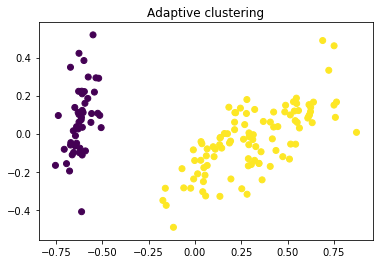

lambda 2.0
h_k 0.370384206011
h_k 0.384220871577
h_k 0.391298573263
h_k 0.401707546026
h_k 0.411089916649
h_k 0.422264349076
h_k 0.439819576956
h_k 0.470506686176
h_k 0.518081273987
h_k 0.54355095521
h_k 0.576939385997
h_k 0.623806866916
h_k 0.690344751627
h_k 0.762065674338
h_k 0.837375321759
h_k 0.876241529892
lambda  2.0 silhouette score: 0.635263270368 0.659113077493 rand_score: 0.568115942029


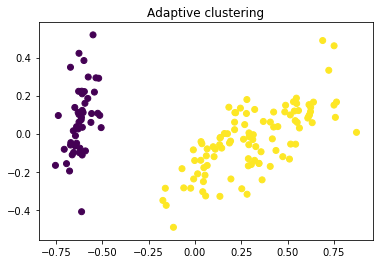

lambda 5.0
h_k 0.370384206011
h_k 0.384220871577
h_k 0.391298573263
h_k 0.401707546026
h_k 0.411089916649
h_k 0.422264349076
h_k 0.439819576956
h_k 0.470506686176
h_k 0.518081273987
h_k 0.54355095521
h_k 0.576939385997
h_k 0.623806866916
h_k 0.690344751627
h_k 0.762065674338
h_k 0.837375321759
h_k 0.876241529892
lambda  5.0 silhouette score: 0.635263270368 0.659113077493 rand_score: 0.568115942029


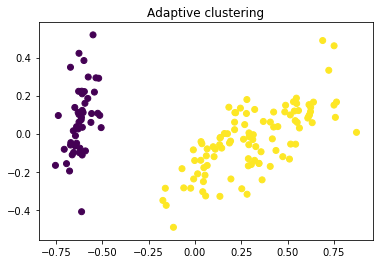

Best lambda 0.5 0.5
h_k 0.370384206011
h_k 0.384220871577
h_k 0.391298573263
h_k 0.401707546026
h_k 0.411089916649
h_k 0.422264349076
h_k 0.439819576956
h_k 0.470506686176
h_k 0.518081273987
h_k 0.54355095521
h_k 0.576939385997
h_k 0.623806866916
h_k 0.690344751627
h_k 0.762065674338
h_k 0.837375321759
h_k 0.876241529892
adjusted_rand_score 0.568115942029


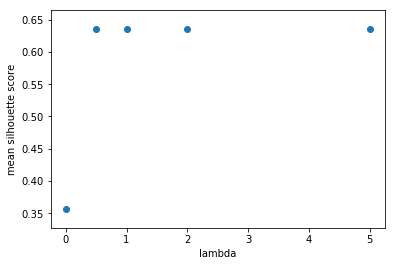

In [330]:
dn = 'iris'
(data,labels)  = cluster_data[dn]
#####
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
pca.fit(data)
data_pca = pca.transform(data)
data_pca.shape
####
result = run_adaptive_clustering(data_pca,labels,n0=5,lb_range=[0.01,0.5,1.0,2.0,5.0])

lambda -0.5
lambda  -0.5 S 648 silhouette score: -0.0915230902812 0.0554296098011 rand_score: 0.0744634558723


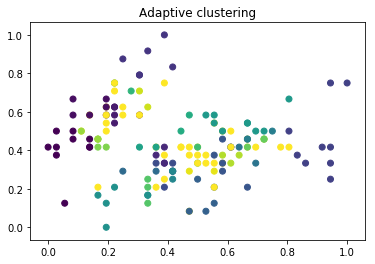

lambda -0.2
lambda  -0.2 S 838 silhouette score: -0.00246460417064 0.140173057656 rand_score: 0.101917808219


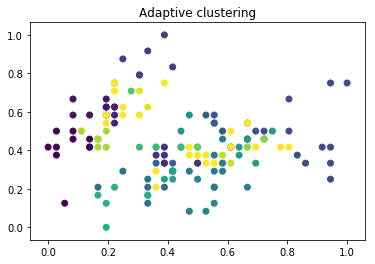

lambda -0.15
lambda  -0.15 S 974 silhouette score: 0.0318120297079 0.190268234392 rand_score: 0.124965960879


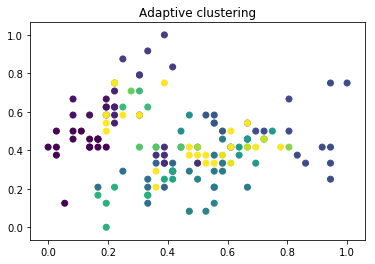

lambda -0.1
lambda  -0.1 S 1180 silhouette score: 0.0320697804799 0.159831019408 rand_score: 0.16087930887


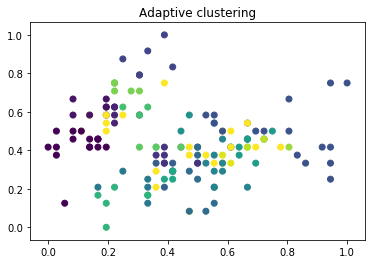

lambda 0
lambda  0 S 3154 silhouette score: 0.201862051966 0.292844999747 rand_score: 0.330838323353


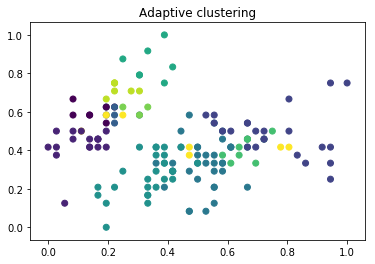

lambda 0.1
lambda  0.1 S 10954 silhouette score: 0.373677455207 0.504753781696 rand_score: 0.439855692664


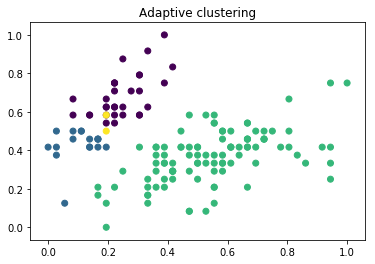

lambda 1.0
lambda  1.0 S 12200 silhouette score: 0.629467556191 0.651146350045 rand_score: 0.568115942029


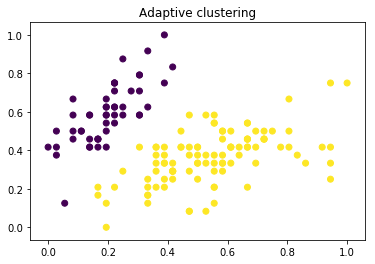

lambda 2
lambda  2 S 12200 silhouette score: 0.629467556191 0.651146350045 rand_score: 0.568115942029


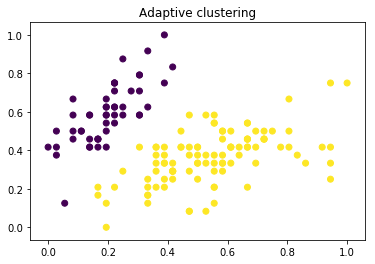

Best lambda 1.0 1.0
adjusted_rand_score 0.568115942029


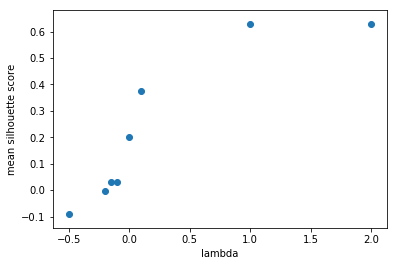

In [115]:
dn = 'iris'
(data,labels)  = cluster_data[dn]
result = run_adaptive_clustering(data,labels,n0=5,
                                 lb_range=[-0.5,-0.2,-0.15,-0.1,0,0.1,1.0,2],
                                assign_outliers = 'new_cluster')

### leaves

In [332]:
dn = 'leaves'
(data,labels)  = cluster_data[dn]
#####
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
pca.fit(data)
data_pca = pca.transform(data)
data_pca.shape
####
result = run_adaptive_clustering(data_pca,labels,lb_range=[0.01,0.5,1.0,2.0,5.0])

lambda 0.01
h_k 1.94077436617


KeyboardInterrupt: 

### wdbc

lambda 0.01
h_k 1.0719404097
h_k 1.09960225256
h_k 1.16162199899
h_k 1.21216204184
h_k 1.28600287812
h_k 1.38343488127
h_k 1.44328972546
h_k 1.54002064325
h_k 1.60973802752
h_k 1.70286803585
lambda  0.01 silhouette score: -0.236956142718 -0.347640403439 rand_score: -0.0135722374348


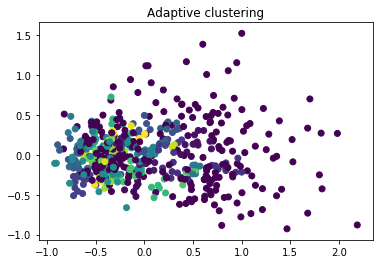

lambda 0.5
h_k 1.0719404097
h_k 1.09960225256
h_k 1.16162199899
h_k 1.21216204184
h_k 1.28600287812
h_k 1.38343488127
h_k 1.44328972546
h_k 1.54002064325
h_k 1.60973802752
h_k 1.70286803585
lambda  0.5 silhouette score: -0.342433898648 -0.395341627745 rand_score: -0.000941184329722


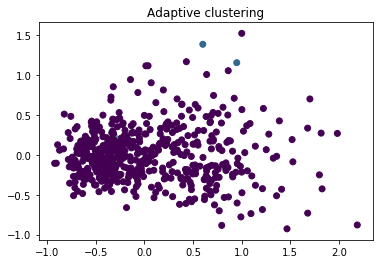

lambda 1.0
h_k 1.0719404097
h_k 1.09960225256
h_k 1.16162199899
h_k 1.21216204184
h_k 1.28600287812
h_k 1.38343488127
h_k 1.44328972546
h_k 1.54002064325
h_k 1.60973802752
h_k 1.70286803585
lambda  1.0 silhouette score: 0.483919667984 0.585854620357 rand_score: 0.00334434207408


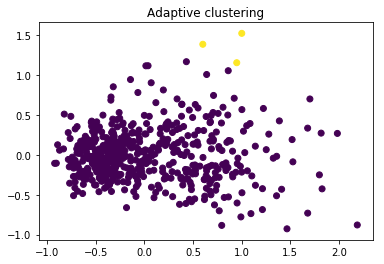

lambda 2.0
h_k 1.0719404097
h_k 1.09960225256
h_k 1.16162199899
h_k 1.21216204184
h_k 1.28600287812
h_k 1.38343488127
h_k 1.44328972546
h_k 1.54002064325
h_k 1.60973802752
h_k 1.70286803585
lambda  2.0 silhouette score: 0.483919667984 0.585854620357 rand_score: 0.00334434207408


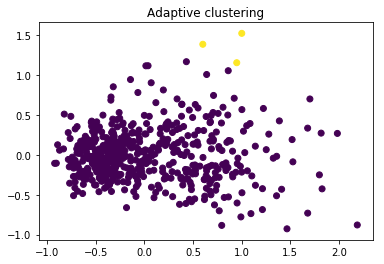

lambda 5.0
h_k 1.0719404097
h_k 1.09960225256
h_k 1.16162199899
h_k 1.21216204184
h_k 1.28600287812
h_k 1.38343488127
h_k 1.44328972546
h_k 1.54002064325
h_k 1.60973802752
h_k 1.70286803585
lambda  5.0 silhouette score: 0.494695170207 0.589800060669 rand_score: 0.000947452447498


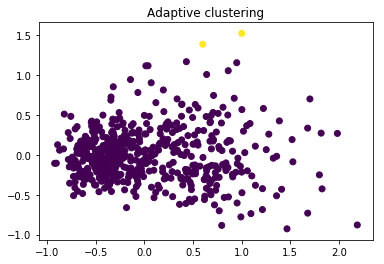

Best lambda 5.0 5.0
h_k 1.0719404097
h_k 1.09960225256
h_k 1.16162199899
h_k 1.21216204184
h_k 1.28600287812
h_k 1.38343488127
h_k 1.44328972546
h_k 1.54002064325
h_k 1.60973802752
h_k 1.70286803585
adjusted_rand_score 0.000947452447498


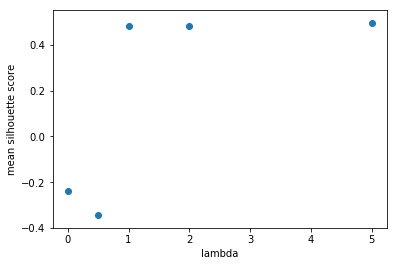

In [333]:
dn = 'wdbc'
(data,labels)  = cluster_data[dn]
#####
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
pca.fit(data)
data_pca = pca.transform(data)
data_pca.shape
####
result = run_adaptive_clustering(data_pca,labels,lb_range=[0.01,0.5,1.0,2.0,5.0])

lambda -0.5
lambda  -0.5 S 43397 silhouette score: -0.395798630553 -0.445504898131 rand_score: 0.0347663718293


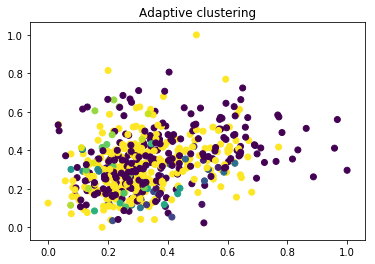

lambda -0.2
lambda  -0.2 S 78437 silhouette score: -0.346228659654 -0.357285251352 rand_score: 0.0458652404524


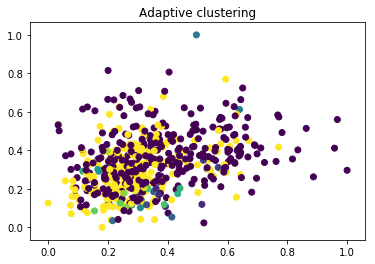

lambda -0.15
lambda  -0.15 S 80017 silhouette score: -0.347032283523 -0.3604379943 rand_score: 0.0406959416471


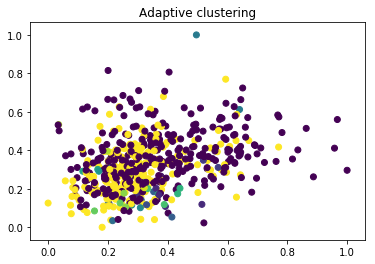

lambda -0.1
lambda  -0.1 S 81129 silhouette score: -0.346002506331 -0.359206163091 rand_score: 0.0439021344322


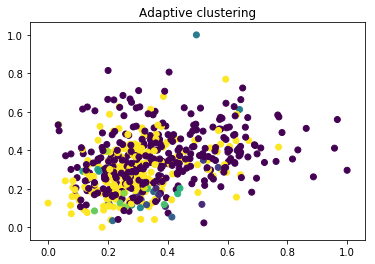

lambda 0
lambda  0 S 99287 silhouette score: -0.347551558223 -0.364250965539 rand_score: 0.0222633737846


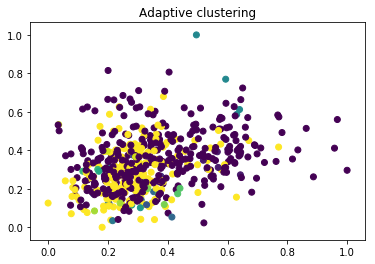

lambda 0.1
lambda  0.1 S 117204 silhouette score: -0.330010329612 -0.324413644359 rand_score: 0.0135580887384


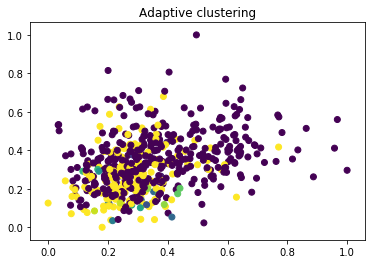

lambda 1.0
lambda  1.0 S 173895 silhouette score: -0.271431652319 -0.274034647903 rand_score: -0.0296456127344


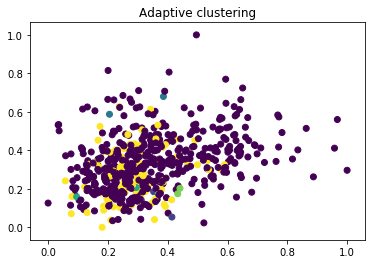

lambda 2
lambda  2 S 198708 silhouette score: -0.228839703319 -0.259301758389 rand_score: -0.0359255284315


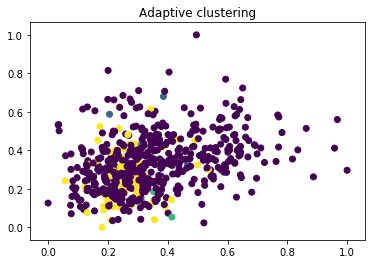

Best lambda 2 2
adjusted_rand_score -0.0359255284315


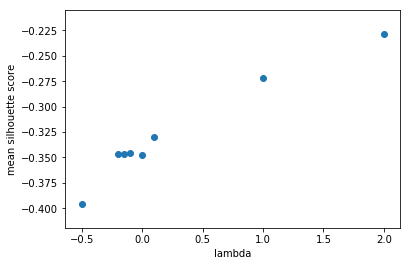

In [116]:
dn = 'wdbc'
(data,labels)  = cluster_data[dn]
result = run_adaptive_clustering(data,labels,n0=5,
                                 lb_range=[-0.5,-0.2,-0.15,-0.1,0,0.1,1.0,2],
                                assign_outliers = 'new_cluster')